# 0.加载模块 Load module


In [1]:
# 导入所需的库
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import re
import time
import json
import subprocess
import requests
from requests.adapters import HTTPAdapter, Retry

import pubchempy as pcp
from pubchempy import PubChemHTTPError
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

import torch
from torch import nn
from torch.nn import functional as F
import transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
)
from torch.utils.data import Dataset, DataLoader

from d2l import torch as d2l
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
)

import sys
import seaborn as sns
# 设置调色板
# Set palette
sns.set_palette("muted")
# 设置环境变量为false
# Set the environment variable to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 导入模型文件
# Import model files
sys.path.append('.//code')
from model import Net, NetESM

# 导入数据处理文件
# Import dataprocess files
from dataprocess import DataProcess, MyDatasetPredict

In [2]:
# 定义关键词enzyme的原始数据文件
# Define the original file for keyword "enzyme"
DATE = "20240611"
path_source_enzyme = f"../data/data_reviewed_enzyme_{DATE}.tsv"
path_enzyme_tem = path_source_enzyme.replace(f'{DATE}', f'{DATE}_tem')
path_enzyme_SMILES = path_source_enzyme.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义额外的测试数据的原始数据文件
# Define the original files of additional test data
path_source_EC11 = f"../data/data_reviewed_EC11_{DATE}.tsv"
path_source_EC27 = f"../data/data_reviewed_EC27_{DATE}.tsv"
path_source_EC31 = f"../data/data_reviewed_EC31_{DATE}.tsv"
path_source_EC42 = f"../data/data_reviewed_EC42_{DATE}.tsv"
path_source_EC56 = f"../data/data_reviewed_EC56_{DATE}.tsv"
path_source_EC63 = f"../data/data_reviewed_EC63_{DATE}.tsv"
path_source_EC71 = f"../data/data_reviewed_EC71_{DATE}.tsv"

# # 定义具有Catalytic Activity的原始数据文件，DATE后添加01，来区分源于path_source_enzyme的训练集、验证集和测试集文件
# # Define the original data file with Catalytic Activity, add '01' after DATE to distinguish the training set, validation set and test set files originating from path_source_enzyme
# DATE = "20240611"
# DATE += '01'
# path_source_CA = f"../data/data_reviewed_CA_{DATE}.tsv"
# path_CA_tem = path_source_CA.replace(f'{DATE}', f'{DATE}_tem')
# path_CA_SMILES = path_source_CA.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义提取的同一个催化反应的底物/产物的最大数量
# Define the maximum number of substrates/products extracted from the same catalytic reaction
NUMBER_REACTION = 10

# 定义序列聚类的一致性阈值，比如0.8,0.6,0.4
# Define the sequence identity threshold for sequence clustering, e.g., 0.8, 0.6, 0.4
SEQ_IDENTITY = 0.80
# 定义序列聚类的文件
# Define the sequence clustering files
path_infile_fasta = f"../data/review_sequence_{DATE}.fasta"
path_outfile_fasta = f"../data/review_sequence_{DATE}_cdhit_{int(SEQ_IDENTITY*100)}"
CLSTR_FILE = path_outfile_fasta + ".clstr"
path_train_fasta = f"../data/review_sequence_train_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"
path_test_fasta = f"../data/review_sequence_test_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"

# 定义训练集、验证集和测试集文件
# Define the files of training set, validation set, and testing set
path_train_data = f"../data/train_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_valid_data = f"../data/valid_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data = f"../data/test_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_80_100 = f"../data/test_data_80_100_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_60_80 = f"../data/test_data_60_80_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_40_60 = f"../data/test_data_40_60_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"

path_name_to_smiles_cache = '../data/name_to_smiles_cache_20240611.json'
dataProcess = DataProcess(path_name_to_smiles_cache = path_name_to_smiles_cache)

# 5.模型测试 Model testing


In [3]:
# 定义常量
# Define constants
NUMBER_LABEL = 3
BATCH_SIZE = 16*1  # 批次大小 batch size
MAX_LEN_MOL = 256  # 底物分子序列最大长度 Maximum length of substrate molecule sequence
MAX_LEN_SEQ = 1573  # 氨基酸序列最大长度，序列长度的98%分位数 Maximum length of amino acid sequence, 98% percentile of sequence length

train_data = pd.read_csv(path_train_data, sep="\t")
valid_data = pd.read_csv(path_valid_data, sep="\t")
test_data = pd.read_csv(path_test_data, sep="\t")
test_data_80_100 = pd.read_csv(path_test_data_80_100, sep="\t")
test_data_60_80 = pd.read_csv(path_test_data_60_80, sep="\t")
test_data_40_60 = pd.read_csv(path_test_data_40_60, sep="\t")
test_data_0_40 = pd.read_csv(path_test_data_0_40, sep="\t")
train_data.replace(np.nan, "", inplace=True)
valid_data.replace(np.nan, "", inplace=True)
test_data.replace(np.nan, "", inplace=True)
test_data_80_100.replace(np.nan, "", inplace=True)
test_data_60_80.replace(np.nan, "", inplace=True)
test_data_40_60.replace(np.nan, "", inplace=True)
test_data_0_40.replace(np.nan, "", inplace=True)

# 检查是否有可用的GPU，如果有，将设备设置为GPU，否则设置为CPU
# Check if there is an available GPU, if so, set the device to GPU, otherwise set to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 如果有多个GPU，选择其中一个进行训练，比如0,1
# If there are multiple GPUs, choose one of them for training
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")

# 加载预训练的蛋白质语言模型和化学分子语言模型
# Load pre-trained protein language model and chemical molecule language model
prot_bert_tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")
prot_bert_model = AutoModel.from_pretrained("Rostlab/prot_bert")
ESM2_t33_tokenizer = AutoTokenizer.from_pretrained(
    "facebook/esm2_t33_650M_UR50D")
ESM2_t33_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
chemBERTa_MTR_tokenizer = AutoTokenizer.from_pretrained(
    "DeepChem/ChemBERTa-77M-MTR")
chemBERTa_MTR_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
chemBERTa_MLM_tokenizer = AutoTokenizer.from_pretrained(
    "DeepChem/ChemBERTa-77M-MLM")
chemBERTa_MLM_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# 读取数据集
# Read the dataset
PATH_SMILES = path_enzyme_SMILES # 39k数据
# PATH_SMILES = path_CA_SMILES # 151k数据
data01 = pd.read_csv(PATH_SMILES, sep="\t")
data01.replace(np.nan, "", inplace=True)
# 生成词汇表
# Generate vocabulary
product_smiles_vocab = dataProcess.generate_vocab(data=data01)
data01

3213 {'<bos>': 0, '<eos>': 1, '<pad>': 2, '<sep>': 3, '<unk>': 4, 'C': 5, 'C#C': 6, 'C#N': 7, 'C(#N)N': 8, 'C(#N)SO': 9, 'C(#N)[S-]': 10, 'C(=C(C(=O)[O-])[O-])C(=O)O': 11, 'C(=C(C=C(C(=O)O)O)C(=O)O)C(=O)O': 12, 'C(=C(C=O)Cl)C=C(C(=O)O)N': 13, 'C(=CC(=C(C(=O)O)N)C(=O)[O-])C=O': 14, 'C(=CC(=O)C(=O)O)C=C[O-]': 15, 'C(=CC(=O)C=CC(=O)O)C=C(C(=O)[O-])[O-]': 16, 'C(=CC(=O)O)C=C(C(=O)[O-])N': 17, 'C(=CC(=O)O)C=C(C(=O)[O-])[O-]': 18, 'C(=CC(=O)[O-])C(=CC(=O)C(=O)[O-])N': 19, 'C(=CC(=O)[O-])C(=CC(=O)[O-])C(=O)[O-]': 20, 'C(=CC(=O)[O-])C(=CC(=O)[O-])Cl': 21, 'C(=CC(=O)[O-])C(=O)NC=O': 22, 'C(=CC(=O)[O-])C(=O)[O-]': 23, 'C(=CC(=O)[O-])C=CC(=O)[O-]': 24, 'C(=CC=O)C=C(C(=O)O)N': 25, 'C(=N)(N)N': 26, 'C(=N)C(=O)[O-]': 27, 'C(=NO)(N)N': 28, 'C(=O)(C(=O)[O-])NC(=O)N': 29, 'C(=O)(C(=O)[O-])[O-]': 30, 'C(=O)(N)N': 31, 'C(=O)(N)NC(=O)NC(=O)O': 32, 'C(=O)(N)NC(=O)[O-]': 33, 'C(=O)(N)OP(=O)(O)O': 34, 'C(=O)(NC(=O)[O-])NC(=O)[O-]': 35, 'C(=O)(O)[O-]': 36, 'C(=O)=O': 37, 'C(=O)=S': 38, 'C(=O)C(=O)[O-]': 39, '

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AADIFAKFKTSMEVK,coenzyme B,methyl-coenzyme M,,,,,,,,...,CC(C(C(=O)[O-])NC(=O)CCCCCCSSCCS(=O)(=O)[O-])O...,C,,,,,,,,
1,AAVPSGASTGIYEALELRAVEHINKTIAPALVSKLAMQEFMILPVG...,(2R)-2-phosphoglycerate,,,,,,,,,...,C=C(C(=O)O)OP(=O)(O)O,O,,,,,,,,
2,ADAADKPDDPNFFRMVEGFFDRGASIVEDKLVEDLRTKETPEQKKG...,H2O,L-glutamate,NAD(+),,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(CC(=O)O)C(=O)C(=O)O,[NH4+],[H+],,,,,,
3,ADAADKPDDPNFFRMVEGFFDRGASIVEDKLVEDLRTKETPEQKKG...,H2O,L-glutamate,NADP(+),,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(CC(=O)O)C(=O)C(=O)O,[NH4+],[H+],,,,,,
4,ADDINPKEECFFEDDYYEFE,H2O,L-isoleucine,O2,,,,,,,...,CCC(C)C(=O)C(=O)O,OO,[NH4+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39341,XXXXXXXXXXXDGHCIPALGFGTYKPIEVPKSKAMEAANLAIGVGY...,morphine,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(=O)C=C4,[H+],,,,,,,
39342,XXXXXXXXXXXDGHCIPALGFGTYKPIEVPKSKAMEAANLAIGVGY...,morphine,NADP(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(=O)C=C4,[H+],,,,,,,
39343,YGPNELPAEEGKNAESAIEALKEYEPEMGKEIVPGDLVEISVGDKI...,ATP,Ca(2+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[Ca+2],[H+],,,,,,
39344,YIAGLLTGRPNSKAVGPSGVVLTAKQAFELANINSEFYELQPKEGL...,L-phenylalanine,,,,,,,,,...,C1=CC=C(C=C1)C=CC(=O)O,[NH4+],,,,,,,,


In [5]:
# # 定义MyDatasetPredict类
# # Define MyDatasetPredict class
# class MyDatasetPredict(Dataset):
#     def __init__(
#         self,
#         data,
#         product_smiles_vocab,
#         prot_tokenizer,
#         chemBERTa_tokenizer,
#         max_seq_length,
#         max_mol_length,
#     ):
#         self.data = data
#         self.product_smiles_vocab = product_smiles_vocab
#         self.prot_tokenizer = prot_tokenizer
#         self.chemBERTa_tokenizer = chemBERTa_tokenizer
#         self.max_seq_length = max_seq_length
#         self.max_mol_length = max_mol_length

#     def __getitem__(self, index):
#         row = self.data.iloc[index]
#         sequence = row["Sequence"]
#         substrate1 = row.get('reaction1_substrate1_y', '')
#         substrate2 = row.get('reaction1_substrate2_y', '')
#         substrate3 = row.get('reaction1_substrate3_y', '')
#         substrate4 = row.get('reaction1_substrate4_y', '')
#         substrate5 = row.get('reaction1_substrate5_y', '')
#         substrate6 = row.get('reaction1_substrate6_y', '')
#         substrate7 = row.get('reaction1_substrate7_y', '')
#         substrate8 = row.get('reaction1_substrate8_y', '')
#         substrate9 = row.get('reaction1_substrate9_y', '')
#         substrate10 = row.get('reaction1_substrate10_y', '')

#         # 对酶序列进行编码，得到prot_model的输入向量
#         # Encode the enzyme sequence to get the input vector of prot_model
#         # 在序列中插入空格并替换非标准氨基酸
#         # Insert spaces and replace non-standard amino acids in the sequence
#         sequences = [
#             " ".join(re.sub(r"[UZOB]", "X", sequence)) for sequence in [sequence]
#         ]
#         # 对序列进行分词和编码
#         # Segment and encode the sequence
#         sequence_tokens = self.prot_tokenizer.batch_encode_plus(
#             sequences,
#             add_special_tokens=True,
#             padding="max_length",
#             return_tensors="pt",
#             max_length=self.max_seq_length,
#             truncation=True,
#         )
#         # 获取编码向量
#         # Get encoding vector
#         sequence_input_ids = sequence_tokens["input_ids"].clone().detach()
#         sequence_attention_mask = sequence_tokens["attention_mask"].clone(
#         ).detach()

#         # 对底物进行编码，得到chemBERTa的输入向量
#         # Encode the substrate and obtain the input vector of chemBERTa
#         # 对底物SMILES字符串进行分词和编码
#         # Segment and encode the substrate SMILES string
#         substrates = [
#             sort_smiles_by_mw(
#                 np.array(
#                     [
#                         substrate1,
#                         substrate2,
#                         substrate3,
#                         substrate4,
#                         substrate5,
#                         substrate6,
#                         substrate7,
#                         substrate8,
#                         substrate9,
#                         substrate10,
#                     ]
#                 )
#             )
#             for substrate1, substrate2, substrate3, substrate4, substrate5, substrate6, substrate7, substrate8, substrate9, substrate10 in [
#                 (
#                     substrate1,
#                     substrate2,
#                     substrate3,
#                     substrate4,
#                     substrate5,
#                     substrate6,
#                     substrate7,
#                     substrate8,
#                     substrate9,
#                     substrate10,
#                 )
#             ]
#         ]
#         substrates = [
#             f"{substrate1}<sep>{substrate2}<sep>{substrate3}"
#             for substrate1, substrate2, substrate3, _, _, _, _, _, _, _ in substrates
#         ]

#         substrate_tokens = self.chemBERTa_tokenizer.batch_encode_plus(
#             substrates,
#             add_special_tokens=True,
#             padding="max_length",
#             return_tensors="pt",
#             max_length=self.max_mol_length,
#             truncation=True,
#         )
#         # 获取编码向量
#         # Get encoding vector
#         substrate_input_ids = substrate_tokens["input_ids"].clone().detach()
#         substrate_attention_mask = substrate_tokens["attention_mask"].clone(
#         ).detach()

#         return (
#             sequence_input_ids,
#             sequence_attention_mask,
#             substrate_input_ids,
#             substrate_attention_mask,
#         )

#     def __len__(self):
#         return len(self.data)

def predict(model, data, dataProcess):
    '''
    模型在新数据上预测
    Model predicts on new data
    '''
    model.eval()
    product_preds = torch.empty(0, NUMBER_LABEL).to(device)
    product_probs = torch.empty(0, NUMBER_LABEL).to(device)

    # 创建MyDatasetPredict实例
    # Create MyDatasetPredict instance
    dataset = MyDatasetPredict(
        data=data,
        product_smiles_vocab=model.product_smiles_vocab,
        prot_tokenizer=model.prot_tokenizer,
        chemBERTa_tokenizer=model.chemBERTa_tokenizer,
        max_seq_length=model.max_seq_length,
        max_mol_length=model.max_mol_length,
        dataProcess=dataProcess,
    )
    # 创建DataLoader实例
    # Create DataLoader instance
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=BATCH_SIZE,
        pin_memory=True,
    )
    # dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 遍历每个批次
    # Iterate through each batch
    for (
        sequence_input_ids,
        sequence_attention_mask,
        substrate_input_ids,
        substrate_attention_mask,
    ) in dataloader:
        # 如果序列为空，跳过该批次
        # If the sequence is empty, skip the batch
        if sequence_input_ids is None:
            continue
        with torch.no_grad():
            (
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            ) = (
                sequence_input_ids.to(device),
                sequence_attention_mask.to(device),
                substrate_input_ids.to(device),
                substrate_attention_mask.to(device),
            )

            # 调用Net类的前向传播方法，得到预测的催化产物向量
            # Call the forward propagation method of Net class to obtain the predicted catalytic product vector
            predicted_vectors1, predicted_vectors2, predicted_vectors3 = model(
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            )

            # 对预测向量进行归一化，得到概率分布
            # Normalize the prediction vector to obtain the probability distribution
            predicted_probs1 = F.softmax(predicted_vectors1, dim=1)
            predicted_probs2 = F.softmax(predicted_vectors2, dim=1)
            predicted_probs3 = F.softmax(predicted_vectors3, dim=1)

            # 对概率分布进行取最大值，得到类别索引和概率值
            # Take the maximum value of the probability distribution and obtain the category index and probability value
            predicted_values1, predicted_ids1 = torch.max(
                predicted_probs1, dim=1)

            predicted_values2, predicted_ids2 = torch.max(
                predicted_probs2, dim=1)

            predicted_values3, predicted_ids3 = torch.max(
                predicted_probs3, dim=1)

        product_pred = torch.cat(
            (
                predicted_ids1.unsqueeze(1),
                predicted_ids2.unsqueeze(1),
                predicted_ids3.unsqueeze(1),
            ),
            dim=1,
        )
        product_prob = torch.cat(
            (
                predicted_values1.unsqueeze(1),
                predicted_values2.unsqueeze(1),
                predicted_values3.unsqueeze(1),
            ),
            dim=1,
        )

        product_preds = torch.cat((product_preds, product_pred), dim=0)
        product_probs = torch.cat((product_probs, product_prob), dim=0)
        # 手动清理GPU内存
        # Manually clear GPU memory
        torch.cuda.empty_cache()

    df_preds = pd.DataFrame(
        product_preds.cpu().detach().numpy(),
        columns=["product1_pred", "product2_pred", "product3_pred"],
    )
    df_preds['product1_pred'] = df_preds['product1_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    df_preds['product2_pred'] = df_preds['product2_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    df_preds['product3_pred'] = df_preds['product3_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    
    df_probs = pd.DataFrame(
        product_probs.cpu().detach().numpy(),
        columns=["product1_prob", "product2_prob", "product3_prob"],
    )
    df_result = pd.concat([df_preds, df_probs], axis=1)
    return df_result

def calculate_accuracy(y_test, y_pred, vocab):
    '''
    计算测试精度
    Calculate test accuracy
    '''
    # 初始化一个空列表，用于存储每个样本的匹配结果
    # Initialize an empty list to store the matching results of each sample
    acc_arr = []
    balanced_acc_arr = []
    macro_f1_arr = []
    micro_f1_arr = []
    ratio_not_in_vocab_arr = []
    # 遍历列
    # Loop through columns
    for i in range(y_test.shape[1]):
        # 获取第i个样本的真实标签和预测标签
        # Get the true label and predicted label of the i-th sample
        y_true = y_test.iloc[:, i].values
        y_pred_1 = y_pred.iloc[:, i].values
        # 计算accuracy
        # Calculate accuracy
        acc = accuracy_score(y_true, y_pred_1)
        acc_arr.append(acc)
        # 计算balanced_accuracy
        # Calculate balanced_accuracy
        balanced_acc = balanced_accuracy_score(y_true, y_pred_1)
        balanced_acc_arr.append(balanced_acc)
        # 计算macro_f1_score
        # Calculate macro_f1_score
        macro_f1 = f1_score(y_true, y_pred_1, average="macro", zero_division=0)
        macro_f1_arr.append(macro_f1)
        # 计算micro_f1_score
        # Calculate micro_f1_score
        micro_f1 = f1_score(y_true, y_pred_1, average="micro", zero_division=0)
        micro_f1_arr.append(micro_f1)
        # 计算ratio_not_in_vocab
        # Calculate ratio_not_in_vocab
        not_in_vocab_count = np.sum((~np.isin(y_true, list(vocab.token_to_idx.keys())) | (y_true == '<unk>')) & (y_true != ''))
        ratio_not_in_vocab_arr.append(not_in_vocab_count / len(y_true) if len(y_true)>0 else 0)

    # 返回精度
    # Return precision
    return acc_arr, balanced_acc_arr, macro_f1_arr, micro_f1_arr, ratio_not_in_vocab_arr

def model_test(
    net,
    test_data,
    dataProcess,
    folder_name="../model",
    model_name="model01.pth",
    device=device,
):
    '''
    测试模型
    Test model
    '''
    # 加载模型
    # Load model
    MODEL_FOLDER = folder_name
    path_savemodel = f"{MODEL_FOLDER}/{model_name}"
    print(path_savemodel)
    model = net.to(device)
    state_dict = torch.load(path_savemodel, map_location=device)['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    model.load_state_dict(new_state_dict, strict=False)

    # 在测试数据上预测
    # Predict on test data
    product_pred = predict(model=model, data=test_data, dataProcess=dataProcess)

    product_true = test_data[
        ["reaction1_product1_y", "reaction1_product2_y", "reaction1_product3_y"]
    ]
    product_true.reset_index(inplace=True)
    product_true = product_true.replace("", "<pad>")

    # 计算精度
    # calculate accuracy
    acc_arr, balanced_acc_arr, macro_f1_arr, micro_f1_arr, ratio_not_in_vocab = calculate_accuracy(
        product_true.iloc[:, 1:], product_pred.iloc[:, :3], net.product_smiles_vocab
    )
    # 手动清理GPU内存
    # Manually clear GPU memory
    torch.cuda.empty_cache()
    return (acc_arr, balanced_acc_arr, macro_f1_arr, micro_f1_arr, ratio_not_in_vocab)

def draw_acc_bar(list_x, dict_arr_acc, xtext=False):
    '''
    绘制模型测试精度柱形图
    Draw model test accuracy column chart
    '''
    # 遍历精度字典dict_arr_acc
    # Traverse the accuracy dictionary dict_arr_acc
    for key, value in dict_arr_acc.items():
        plt.figure(figsize=(8, 6))
        arr = np.array(value)

        width = 0.28
        x = np.arange(len(list_x))
        # 绘制柱形图
        # Draw a column chart
        bars1 = plt.bar(x - width, arr[:, 0], width, label="product1")
        bars2 = plt.bar(x, arr[:, 1], width, label="product2")
        bars3 = plt.bar(x + width, arr[:, 2], width, label="product3")
        # 添加柱形数值
        # Add column values
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                y_value = bar.get_height()
                plt.text(
                    bar.get_x() + width / 2,
                    y_value,
                    f"{y_value:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    rotation=45,
                )

        # plt.grid()
        plt.tight_layout()
        plt.legend(loc="best", fontsize=12, framealpha=0.5)
        plt.xticks(x, list_x, rotation=15, fontsize=10)
        plt.yticks(np.arange(0, 1.1, step=0.2), fontsize=11)
        plt.ylim((0,1.1))
        if xtext:
            plt.xlabel(xtext, fontsize=12)
        plt.ylabel(key, fontsize=12)
    plt.show()

比较四种表示策略
Comparing four representation strategies ProtBert/ESM2 + ChemBERTa-2-MTR/MLM

In [6]:
def calculate_multi_model(list_model, dataProcess, device):
    '''
    计算多个模型的测试精度
    Calculate test accuracy for multiple models
    '''
    arr_acc = []
    arr_balanced_acc = []
    arr_macro_f1 = []
    arr_micro_f1 = []
    arr_ratio_not_in_vocab = []
    for i in range(len(list_model)):
        dict_model = list_model[i]
        print(dict_model['model_name'])

        acc_arr, balanced_acc_arr, macro_f1_arr, micro_f1_arr, ratio_not_in_vocab = model_test(
            net=dict_model["net"],
            test_data=dict_model['test_data'],
            dataProcess=dataProcess,
            folder_name=dict_model["path_folder"],
            model_name=dict_model["path_model"],
            device=device,
        )
        arr_acc.append(acc_arr)
        arr_balanced_acc.append(balanced_acc_arr)
        arr_macro_f1.append(macro_f1_arr)
        arr_micro_f1.append(micro_f1_arr)
        arr_ratio_not_in_vocab.append(ratio_not_in_vocab)

    return (arr_acc, arr_balanced_acc, arr_macro_f1, arr_micro_f1, arr_ratio_not_in_vocab)

# 实例化模型
# Instantiate the model
net01 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
net02 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MLM_model,
    chemBERTa_MLM_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
net03 = NetESM(
    ESM2_t33_model,
    ESM2_t33_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
net04 = NetESM(
    ESM2_t33_model,
    ESM2_t33_tokenizer,
    chemBERTa_MLM_model,
    chemBERTa_MLM_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)

In [10]:
list_model = [
    {
        "model_name": "ProtBert+ChemBERTa-2-MTR",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data,
    },
    {
        "model_name": "ProtBert+ChemBERTa-2-MLM",
        "net": net02,
        "path_model": "model02_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data,
    },
    {
        "model_name": "ESM2+ChemBERTa-2-MTR",
        "net": net03,
        "path_model": "model03_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data,
    },
    {
        "model_name": "ESM2+ChemBERTa-2-MLM",
        "net": net04,
        "path_model": "model04_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data,
    },
]

print(train_data.shape, valid_data.shape, test_data.shape, test_data_80_100.shape, test_data_60_80.shape, test_data_40_60.shape, test_data_0_40.shape)

arr_acc01, arr_balanced_acc01, arr_macro_f101, arr_micro_f101, arr_ratio_not_in_vocab01 = calculate_multi_model(
    list_model=list_model, 
    dataProcess=dataProcess,
    device=device
)

(31470, 7) (3150, 7) (4726, 7) (562, 7) (1821, 7) (1192, 7) (1151, 7)
ProtBert+ChemBERTa-2-MTR
../model/model01_39k_80.pth


[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not removing hydrogen atom without neighbors
[10:56:12] WARNING: not r

ProtBert+ChemBERTa-2-MLM
../model/model02_39k_80.pth


[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not removing hydrogen atom without neighbors
[11:00:27] WARNING: not r

ESM2+ChemBERTa-2-MTR
../model/model03_39k_80.pth


[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not removing hydrogen atom without neighbors
[11:04:49] WARNING: not r

ESM2+ChemBERTa-2-MLM
../model/model04_39k_80.pth


[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not removing hydrogen atom without neighbors
[11:14:33] WARNING: not r

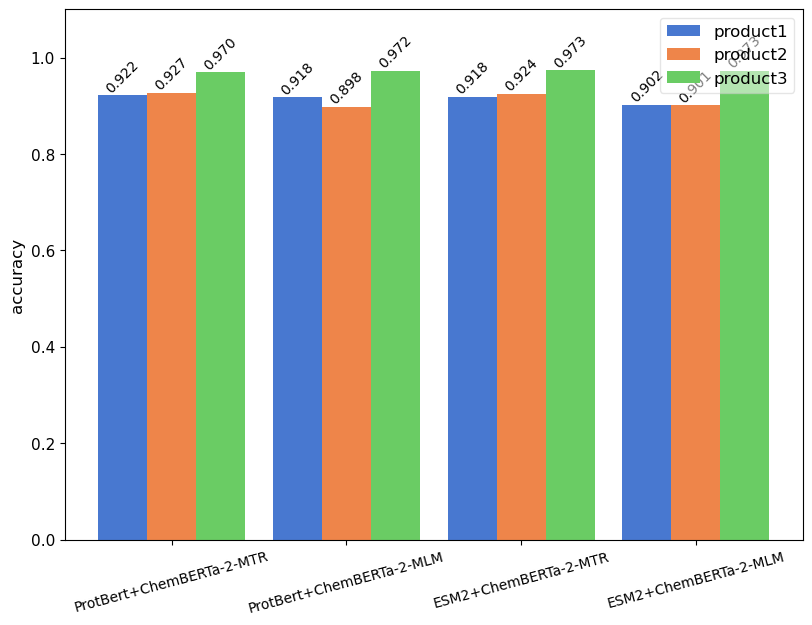

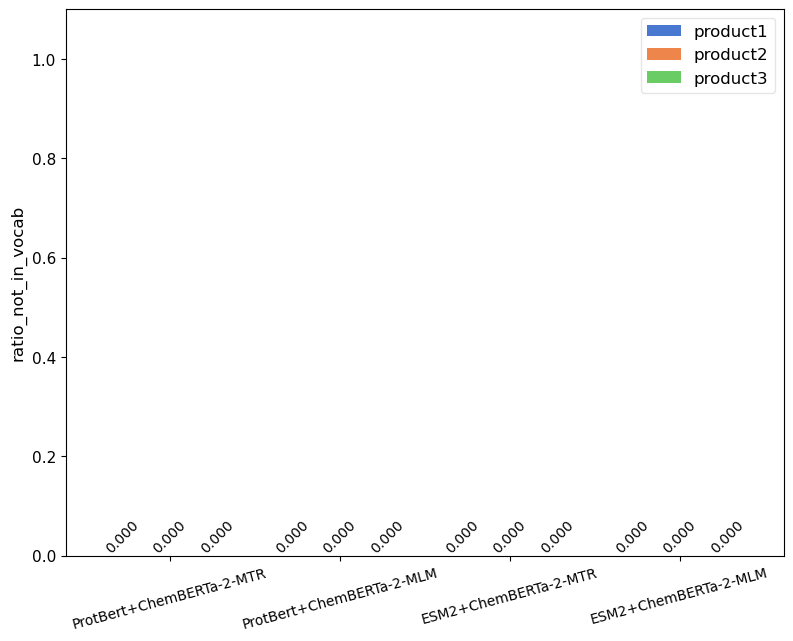

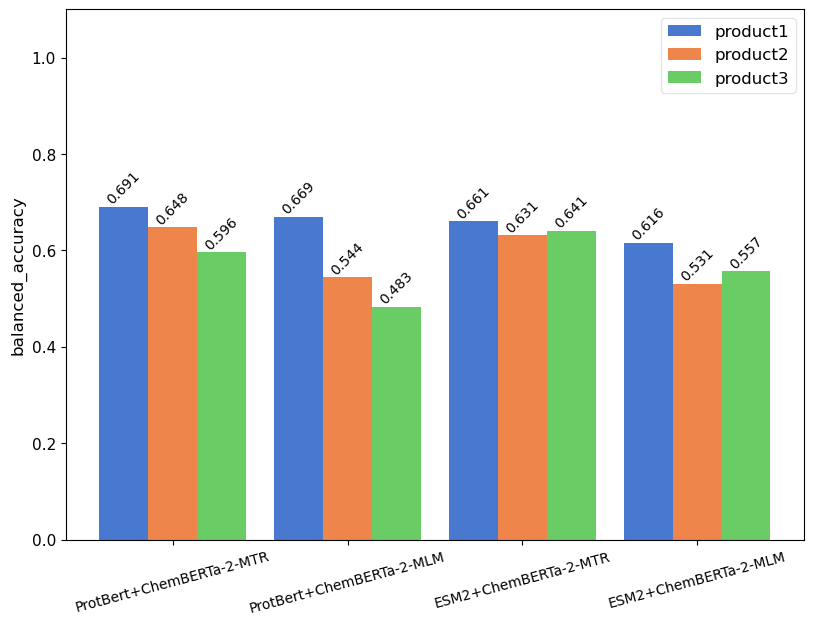

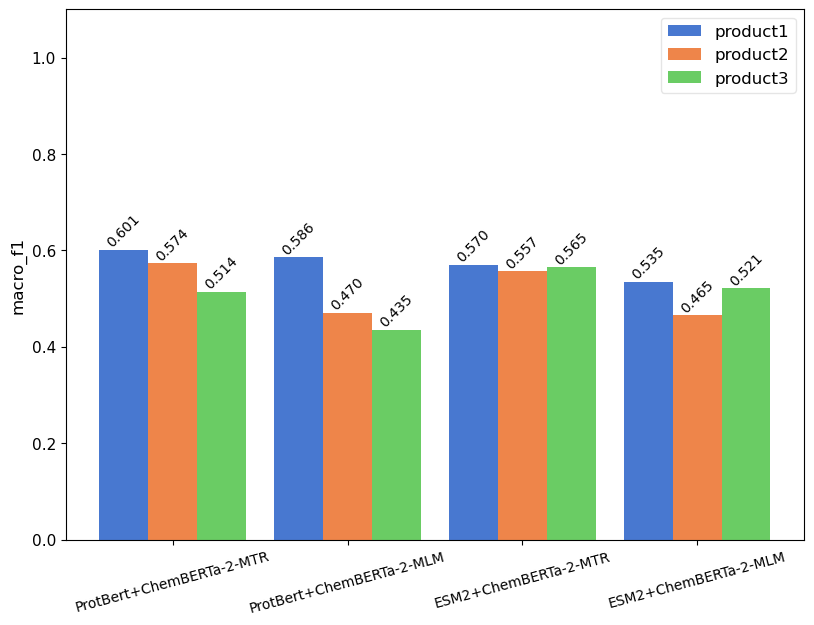

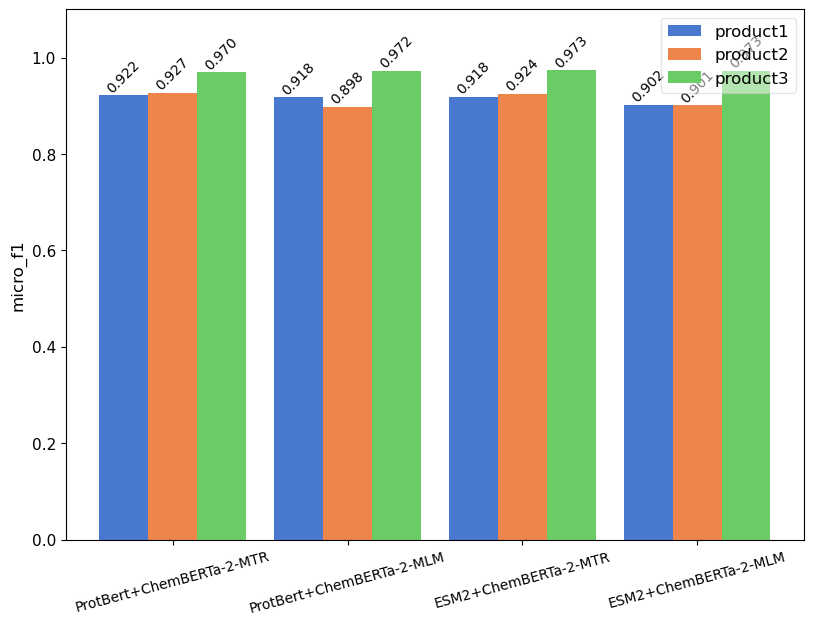

In [11]:
dict_arr_acc01 = {
    "accuracy": arr_acc01,
    'ratio_not_in_vocab': arr_ratio_not_in_vocab01,
    "balanced_accuracy": arr_balanced_acc01,
    "macro_f1": arr_macro_f101,
    "micro_f1": arr_micro_f101,
}

draw_acc_bar(
    list_x=[x["model_name"] for x in list_model],
    dict_arr_acc=dict_arr_acc01,
    xtext="",
)

比较不同 identity 的测试集上的预测精度
Compare prediction accuracy on test sets of different identities


(31467, 7) (3151, 7) (4728, 7) (580, 7) (1816, 7) (1211, 7) (1121, 7)
model model01_39k_80.pth all
model/model01_39k_80.pth


[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not removing hydrogen atom without neighbors
[21:09:55] WARNING: not r

model model01_39k_80.pth 0-40%
model/model01_39k_80.pth


[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not removing hydrogen atom without neighbors
[21:16:17] WARNING: not r

model model01_39k_80.pth 40-60%
model/model01_39k_80.pth


[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not removing hydrogen atom without neighbors
[21:17:51] WARNING: not r

model model01_39k_80.pth 60-80%
model/model01_39k_80.pth


[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not removing hydrogen atom without neighbors
[21:19:31] WARNING: not r

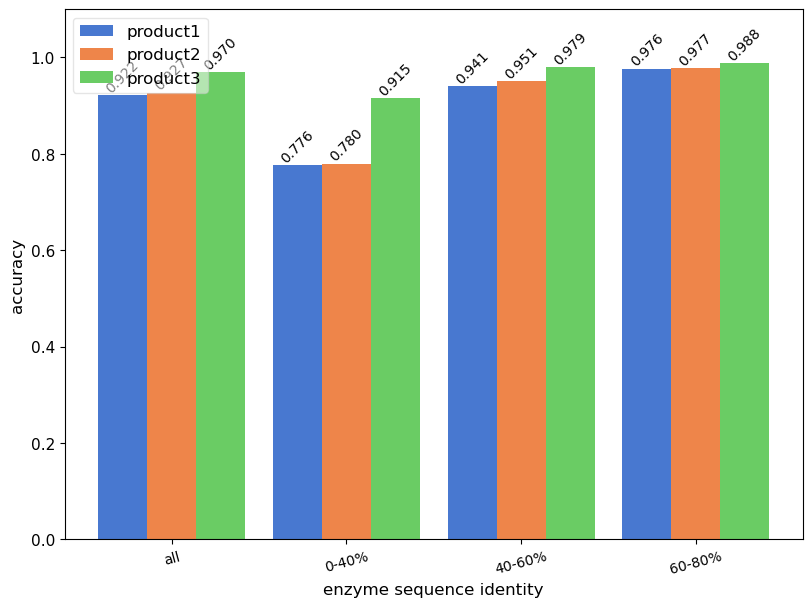

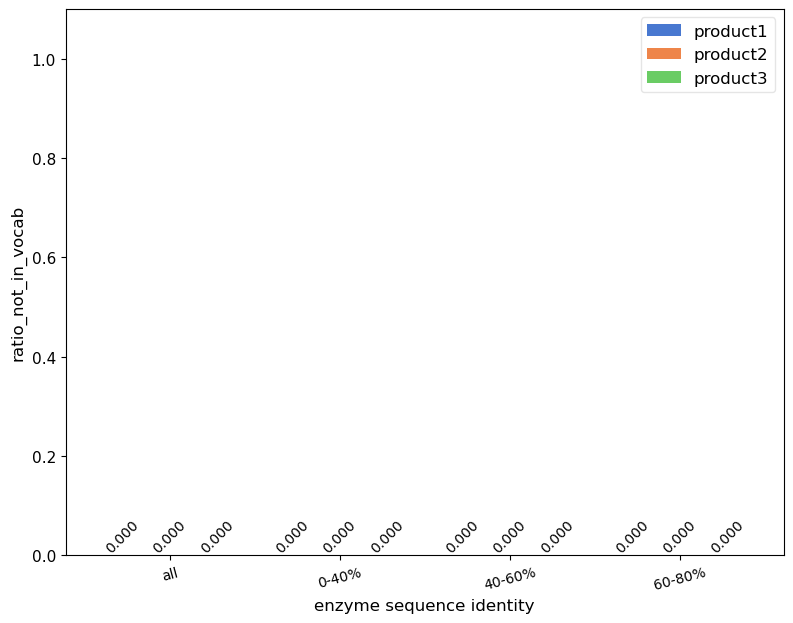

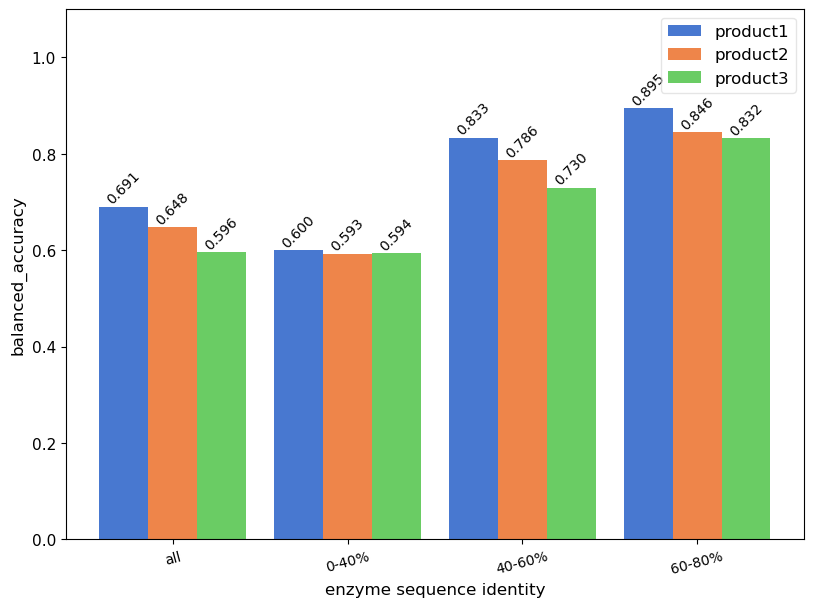

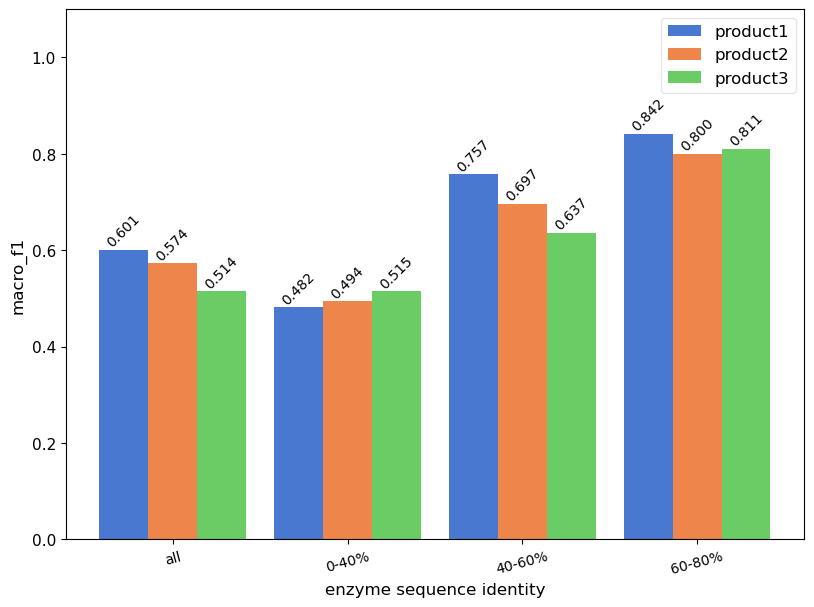

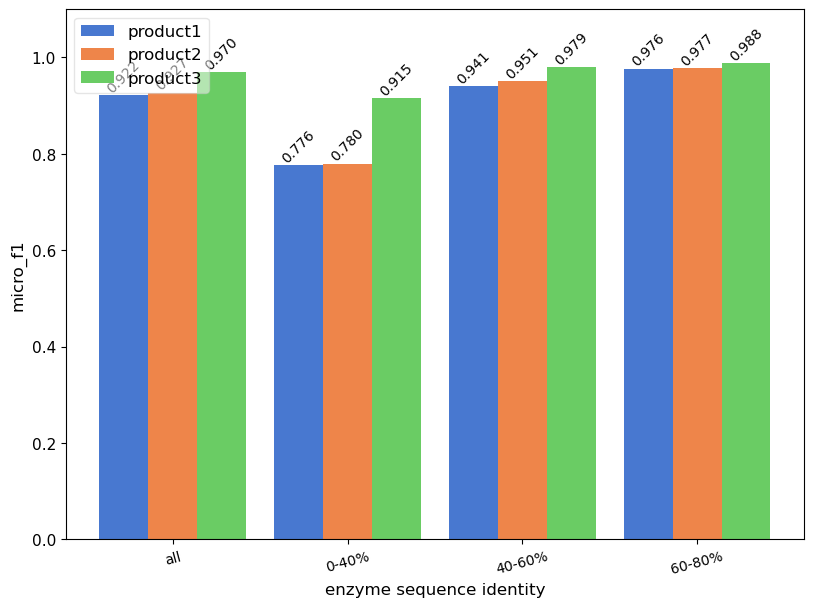

In [12]:
list_model = [
    {
        "model_name": "all",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data,
    },
    {
        "model_name": "0-40%",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_0_40,
    },
    {
        "model_name": "40-60%",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_40_60,
    },
    {
        "model_name": "60-80%",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_60_80,
    }
]

print(train_data.shape, valid_data.shape, test_data.shape, test_data_80_100.shape, test_data_60_80.shape, test_data_40_60.shape, test_data_0_40.shape)

arr_acc02, arr_balanced_acc02, arr_macro_f102, arr_micro_f102, arr_ratio_not_in_vocab02 = calculate_multi_model(
    list_model=list_model, 
    dataProcess=dataProcess,
    device=device
)
dict_arr_acc02 = {
    "accuracy": arr_acc02,
    'ratio_not_in_vocab': arr_ratio_not_in_vocab02,
    "balanced_accuracy": arr_balanced_acc02,
    "macro_f1": arr_macro_f102,
    "micro_f1": arr_micro_f102,
}
draw_acc_bar(
    list_x=[x["model_name"] for x in list_model],
    dict_arr_acc=dict_arr_acc02,
    xtext="enzyme sequence identity",
)

(1121, 7) (1633, 7) (2993, 7)
model model01_39k_80.pth EPP_39k_80
model/model01_39k_80.pth


[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not removing hydrogen atom without neighbors
[21:22:02] WARNING: not r

model model01_39k_60.pth EPP_39k_60
model/model01_39k_60.pth


[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not removing hydrogen atom without neighbors
[21:23:35] WARNING: not r

model model01_39k_40.pth EPP_39k_40
model/model01_39k_40.pth


[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not removing hydrogen atom without neighbors
[21:25:49] WARNING: not r

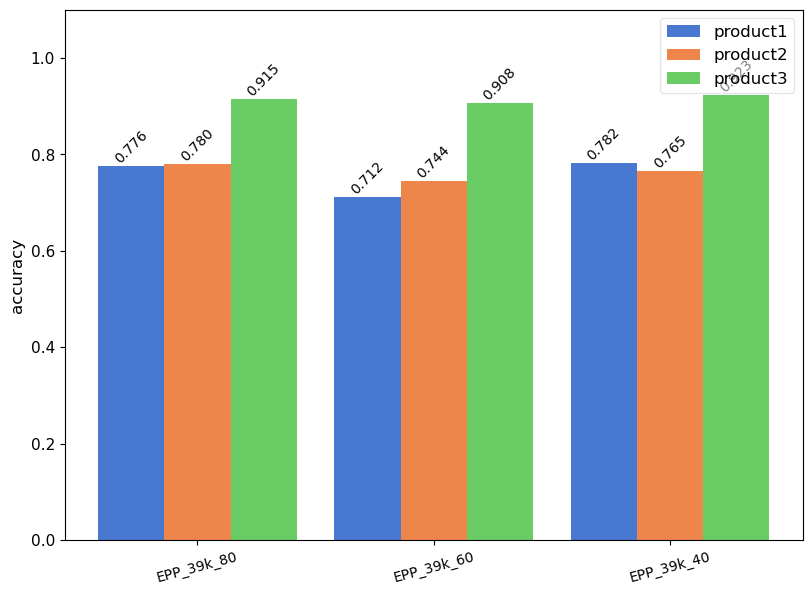

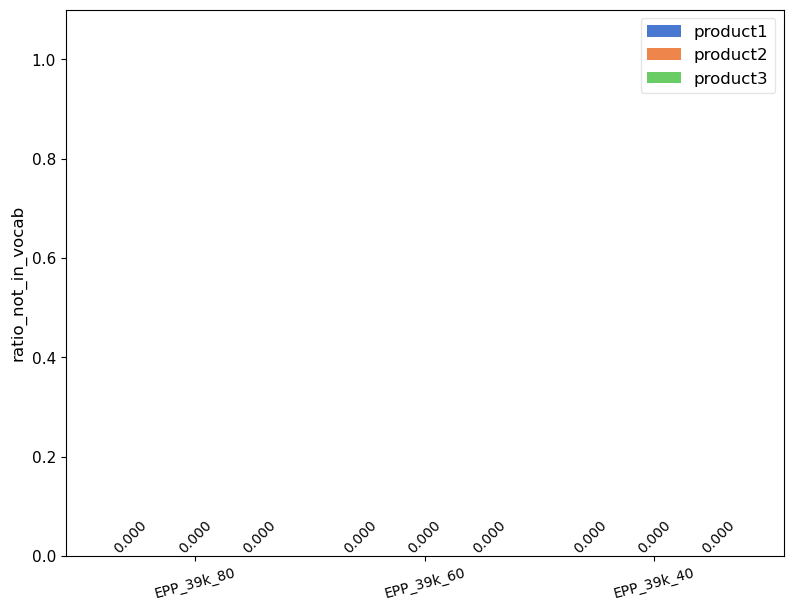

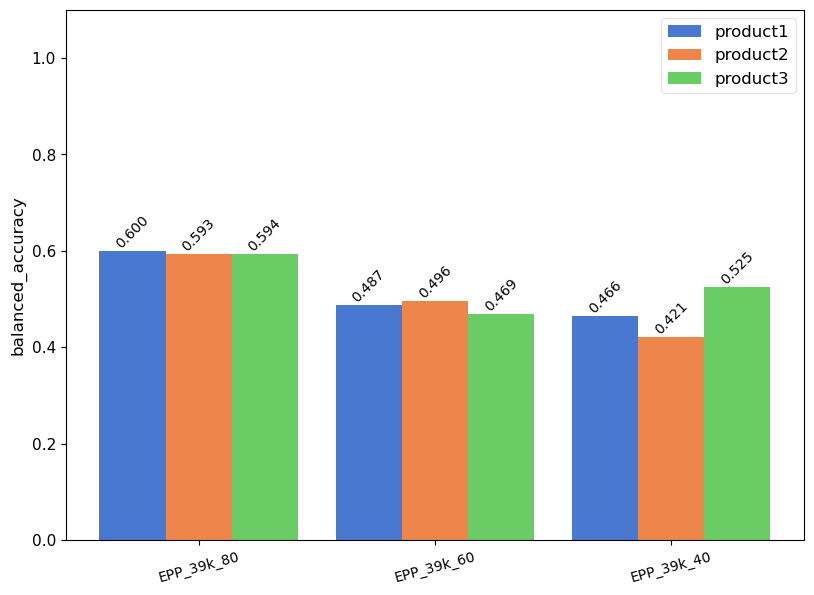

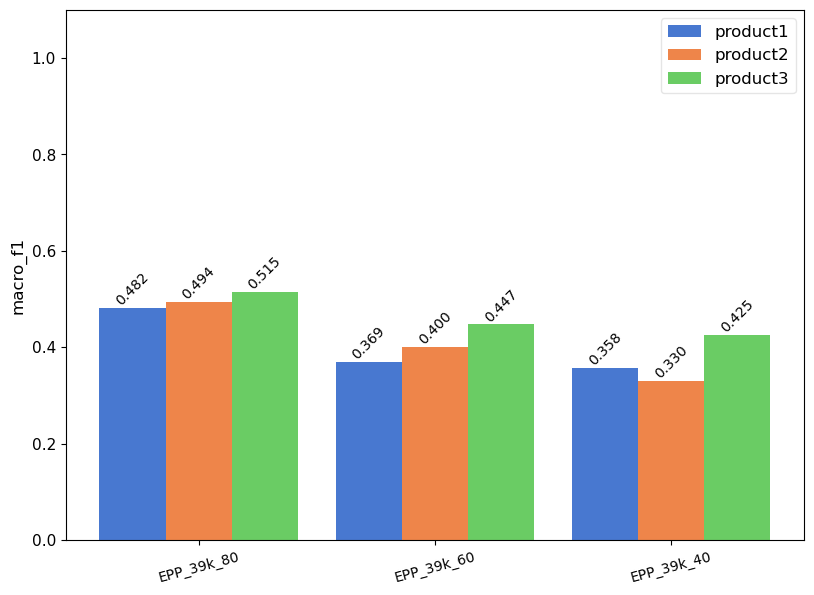

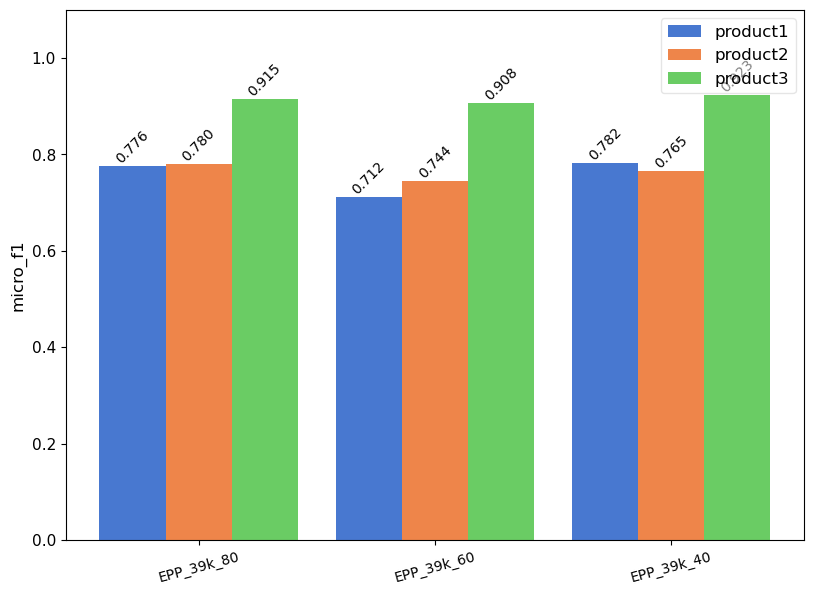

In [13]:
# 不同模型在低序列一致性数据上的预测效果
# Prediction effects of different models on low sequence consistency data
SEQ_IDENTITY01 = 0.80

path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY01*100)}.tsv"
test_data_0_40_80 = pd.read_csv(path_test_data_0_40, sep="\t")
test_data_0_40_80.replace(np.nan, "", inplace=True)

SEQ_IDENTITY02 = 0.60

path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY02*100)}.tsv"
test_data_0_40_60 = pd.read_csv(path_test_data_0_40, sep="\t")
test_data_0_40_60.replace(np.nan, "", inplace=True)

SEQ_IDENTITY03 = 0.40

path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY03*100)}.tsv"
test_data_0_40_40 = pd.read_csv(path_test_data_0_40, sep="\t")
test_data_0_40_40.replace(np.nan, "", inplace=True)

list_model = [
    {
        "model_name": "EPP_39k_80",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_0_40_80,
    },
    {
        "model_name": "EPP_39k_60",
        "net": net01,
        "path_model": "model01_39k_60.pth",
        "path_folder": "../model",
        'test_data': test_data_0_40_60,
    },
    {
        "model_name": "EPP_39k_40",
        "net": net01,
        "path_model": "model01_39k_40.pth",
        "path_folder": "../model",
        'test_data': test_data_0_40_40,
    },
    
]

print(test_data_0_40_80.shape, test_data_0_40_60.shape, test_data_0_40_40.shape)

arr_acc02, arr_balanced_acc02, arr_macro_f102, arr_micro_f102, arr_ratio_not_in_vocab02 = calculate_multi_model(
    list_model=list_model, 
    dataProcess=dataProcess,
    device=device
)
dict_arr_acc023 = {
    "accuracy": arr_acc02,
    'ratio_not_in_vocab': arr_ratio_not_in_vocab02,
    "balanced_accuracy": arr_balanced_acc02,
    "macro_f1": arr_macro_f102,
    "micro_f1": arr_micro_f102,
}
draw_acc_bar(
    list_x=[x["model_name"] for x in list_model],
    dict_arr_acc=dict_arr_acc023,
    xtext="",
)

预测精度与预测概率的关系
The relationship between prediction accuracy and prediction probability

In [9]:
def model_test_prob(
    net,
    test_data,
    dataProcess,
    folder_name="../model",
    model_name="model01.pth",
    device=device,
):
    '''
    计算不同预测概率的模型预测精度
    Calculate model prediction accuracy with different prediction probabilities
    '''
    MODEL_FOLDER = folder_name
    path_savemodel = f"{MODEL_FOLDER}/{model_name}"
    print(path_savemodel)
    # 加载模型
    # Load model
    model = net.to(device)
    state_dict = torch.load(path_savemodel, map_location=device)['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    model.load_state_dict(new_state_dict, strict=False)

    product_pred = predict(model=model, data=test_data, dataProcess=dataProcess)
    
    product_true = test_data[
        ["reaction1_product1_y", "reaction1_product2_y", "reaction1_product3_y"]
    ]
    product_true.reset_index(inplace=True)
    product_true = product_true.replace("", "<pad>")
    print(product_true.shape)
    # 左右合并
    # Merge left and right
    df_product = pd.concat([product_true, product_pred], axis=1)
    # 根据不同的预测概率来评估模型
    # Evaluate the model based on different predicted probabilities
    dict_result = {}
    step_x = 0.1
    for prob in ['product1_prob', 'product2_prob', 'product3_prob']:
        dict_prob = {}
        for x in np.arange(0, 1.0, step_x):
            df_product_x = df_product[(
                df_product[prob] >= x) & (df_product[prob] < x+step_x)]
            product_true_x = df_product_x[['reaction1_product1_y', 'reaction1_product2_y', 'reaction1_product3_y']]
            product_pred_x = df_product_x[['product1_pred', 'product2_pred', 'product3_pred']]
            # 调用函数，计算精度
            # Call the function and calculate the accuracy
            acc_arr, balanced_acc_arr, macro_f1_arr, micro_f1_arr, ratio_not_in_vocab = calculate_accuracy(
                product_true_x, product_pred_x, vocab=net.product_smiles_vocab
            )

            dict_prob[x] = {
                "accuracy": acc_arr,
                'ratio_not_in_vocab': ratio_not_in_vocab,
                "balanced_accuracy": balanced_acc_arr,
                "macro_f1": macro_f1_arr,
                "micro_f1": micro_f1_arr,
                "count": df_product_x.shape[0],
            }

        dict_result[prob] = dict_prob
    return dict_result

def draw_acc_prob(dict_acc_prob, number_label=NUMBER_LABEL, cols=["accuracy", 'ratio_not_in_vocab', 'balanced_accuracy', "macro_f1", "micro_f1"], text='EPP'):
    '''
    绘制不同概率对应的准确率
    Plot the accuracy corresponding to different probabilities
    '''
    # 定义结果
    # define result
    result = []
    for i in range(0, number_label):
        label = f"product{i+1}_prob"
        print(label)
        df_product_prob = pd.DataFrame.from_dict(
            dict_acc_prob[label], orient="index"
        ).reset_index()
        df_product_prob.rename(columns={"index": "prob"}, inplace=True)
        for col in cols:
            df_product_prob[col] = df_product_prob.apply(
                lambda x: x[col][i], axis=1)

        df_product_prob["prob"] = df_product_prob["prob"].astype(float).round(3)

        df_product_prob["count_ratio"] = df_product_prob.apply(
            lambda x: x["count"] / df_product_prob["count"].sum(), axis=1
        )
        result.append(df_product_prob)
        print(df_product_prob)
        # 创建轴对象
        # Create axis object
        ax = plt.gca()
        if 'ratio_not_in_vocab' in cols:
            df_product_prob.plot(
                x="prob",
                y=["ratio_not_in_vocab"],
                kind="line",
                figsize=(12, 8),
                ax=ax,
                use_index=False,
                rot=45,
                marker="+",
                ylabel="ratio_not_in_vocab",
                grid=True,
                ylim=(0, 1),
            )
            
            for x, y in zip(df_product_prob["prob"], df_product_prob["ratio_not_in_vocab"]):
                plt.annotate(
                    xy=(x * 10, y),
                    text=f"{y*100:.2f}%",
                    xytext=(0, 5),
                    textcoords="offset points",
                    fontsize=12,
                )

        df_product_prob.plot(
            x="prob",
            y=["accuracy"],
            kind="line",
            figsize=(12, 8),
            ax=ax,
            use_index=False,
            rot=45,
            marker="+",
            ylabel="accuracy",
            grid=True,
            ylim=(0, 1),
        )
       
        for x, y in zip(df_product_prob["prob"], df_product_prob["accuracy"]):
            plt.annotate(
                xy=(x * 10, y),
                text=f"{y*100:.2f}%",
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=12,
            )
        df_product_prob.plot(
            x="prob",
            y=["count"],
            kind="bar",
            figsize=(12, 8),
            ax=ax,
            use_index=True,
            rot=45,
            color=(0, 1, 1),
            secondary_y=True,
            ylabel="count",
            xlabel="probability",
            alpha=0.5,
            ylim=(0, df_product_prob["count"].sum()),
        )
        # 在x轴刻度标签前添加大于等于符号
        # Add a greater than or equal symbol before the x-axis tick label
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels([">=" + label.get_text()
                           for label in ax.get_xticklabels()])
        plt.title(f"{text}product{i+1}")
        plt.show()
    return result

model/model01_39k_80.pth


[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not removing hydrogen atom without neighbors
[21:29:54] WARNING: not r

(4728, 4)
{'product1_prob': {0.0: {'accuracy': [0.08333333333333333, 0.43333333333333335, 0.8333333333333334], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.09420289855072463, 0.28908045977011493, 0.5850678733031675], 'macro_f1': [0.04349593495934959, 0.21424501424501421, 0.5024943310657596], 'micro_f1': [0.08333333333333333, 0.43333333333333335, 0.8333333333333334], 'count': 60}, 0.1: {'accuracy': [0.12244897959183673, 0.46938775510204084, 0.8775510204081632], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.12280701754385963, 0.38888888888888884, 0.5478191276510603], 'macro_f1': [0.06473429951690822, 0.28768315018315016, 0.4739304812834224], 'micro_f1': [0.12244897959183673, 0.46938775510204084, 0.8775510204081631], 'count': 49}, 0.2: {'accuracy': [0.24615384615384617, 0.47692307692307695, 0.7384615384615385], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.325, 0.38809523809523805, 0.6132621951219512], 'macro_f1': [0.19696969696969696, 0

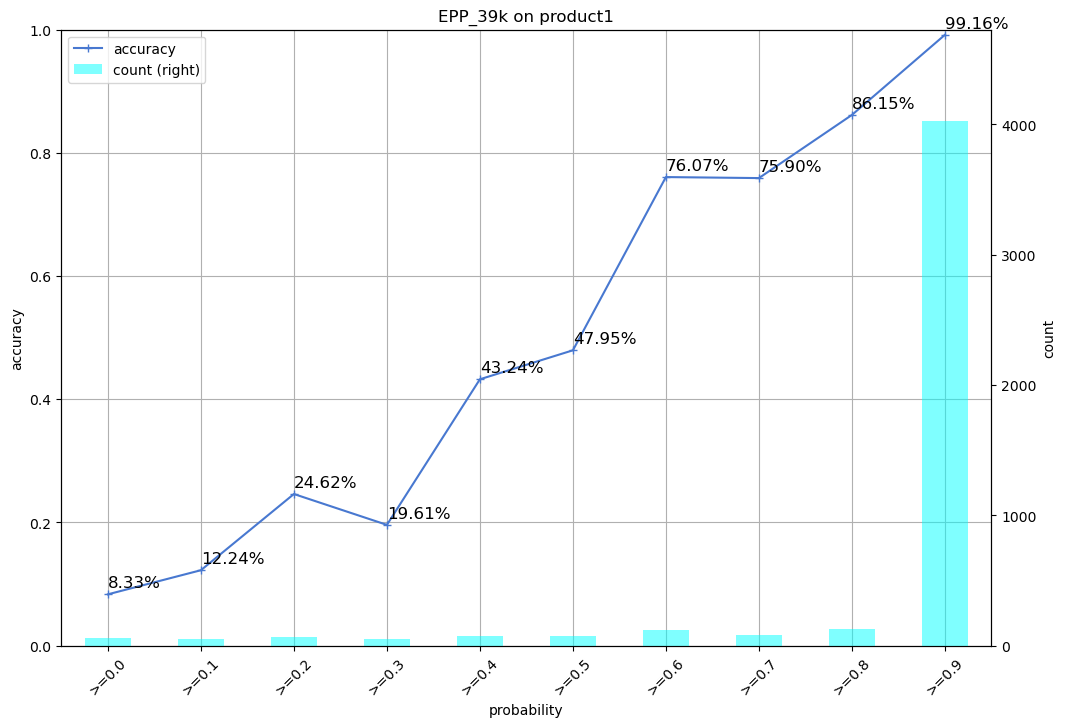

product2_prob
   prob  accuracy ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0  0.000000    [0.0, 0.0, 0.0]           0.000000  0.000000  0.000000   
1   0.1  0.044444    [0.0, 0.0, 0.0]           0.054054  0.028986  0.044444   
2   0.2  0.278689    [0.0, 0.0, 0.0]           0.204545  0.126426  0.278689   
3   0.3  0.407407    [0.0, 0.0, 0.0]           0.422619  0.270952  0.407407   
4   0.4  0.551724    [0.0, 0.0, 0.0]           0.468750  0.353297  0.551724   
5   0.5  0.641304    [0.0, 0.0, 0.0]           0.615217  0.454640  0.641304   
6   0.6  0.627907    [0.0, 0.0, 0.0]           0.647246  0.527922  0.627907   
7   0.7  0.740741    [0.0, 0.0, 0.0]           0.749394  0.624852  0.740741   
8   0.8  0.856164    [0.0, 0.0, 0.0]           0.840904  0.772081  0.856164   
9   0.9  0.989879    [0.0, 0.0, 0.0]           0.929096  0.924989  0.989879   

   count  count_ratio  
0     54     0.011421  
1     45     0.009518  
2     61     0.012902  
3     54     0.01142

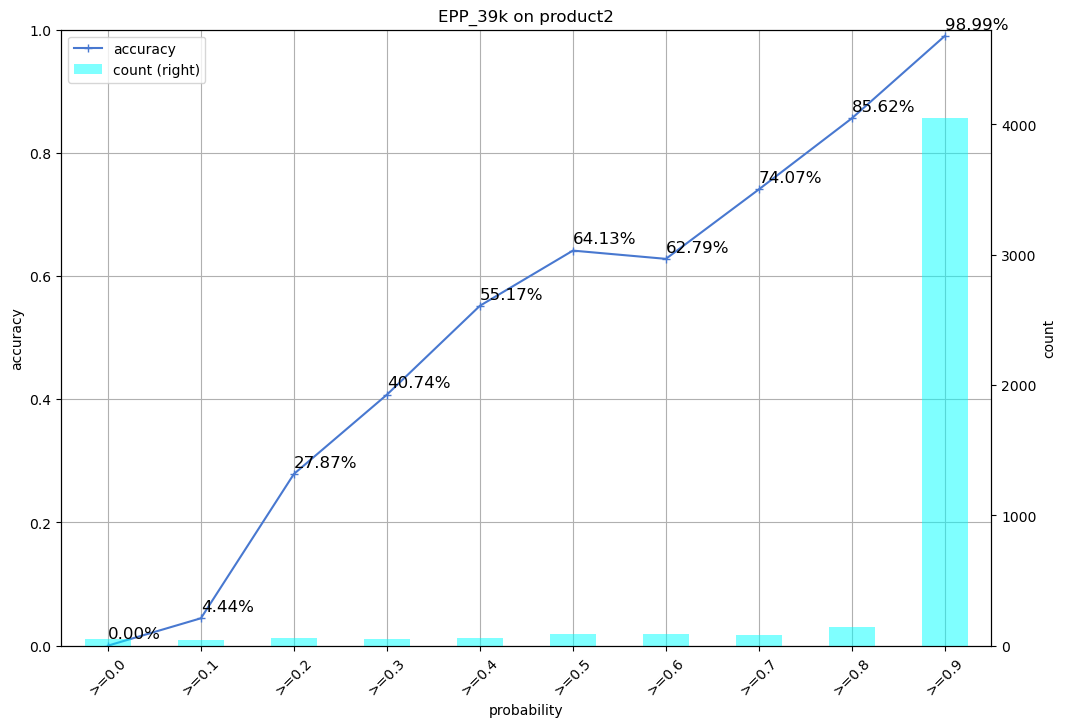

product3_prob
   prob  accuracy ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0       NaN          [0, 0, 0]                NaN       NaN  0.000000   
1   0.1       NaN          [0, 0, 0]                NaN       NaN  0.000000   
2   0.2  0.500000    [0.0, 0.0, 0.0]           0.666667  0.500000  0.500000   
3   0.3  0.500000    [0.0, 0.0, 0.0]           0.500000  0.333333  0.500000   
4   0.4  0.500000    [0.0, 0.0, 0.0]           0.485714  0.367725  0.500000   
5   0.5  0.629630    [0.0, 0.0, 0.0]           0.531944  0.382071  0.629630   
6   0.6  0.627907    [0.0, 0.0, 0.0]           0.564198  0.404366  0.627907   
7   0.7  0.560000    [0.0, 0.0, 0.0]           0.562530  0.483457  0.560000   
8   0.8  0.698925    [0.0, 0.0, 0.0]           0.619048  0.539887  0.698925   
9   0.9  0.987542    [0.0, 0.0, 0.0]           0.690060  0.695769  0.987542   

   count  count_ratio  
0      0     0.000000  
1      0     0.000000  
2      4     0.000846  
3      2     0.00042

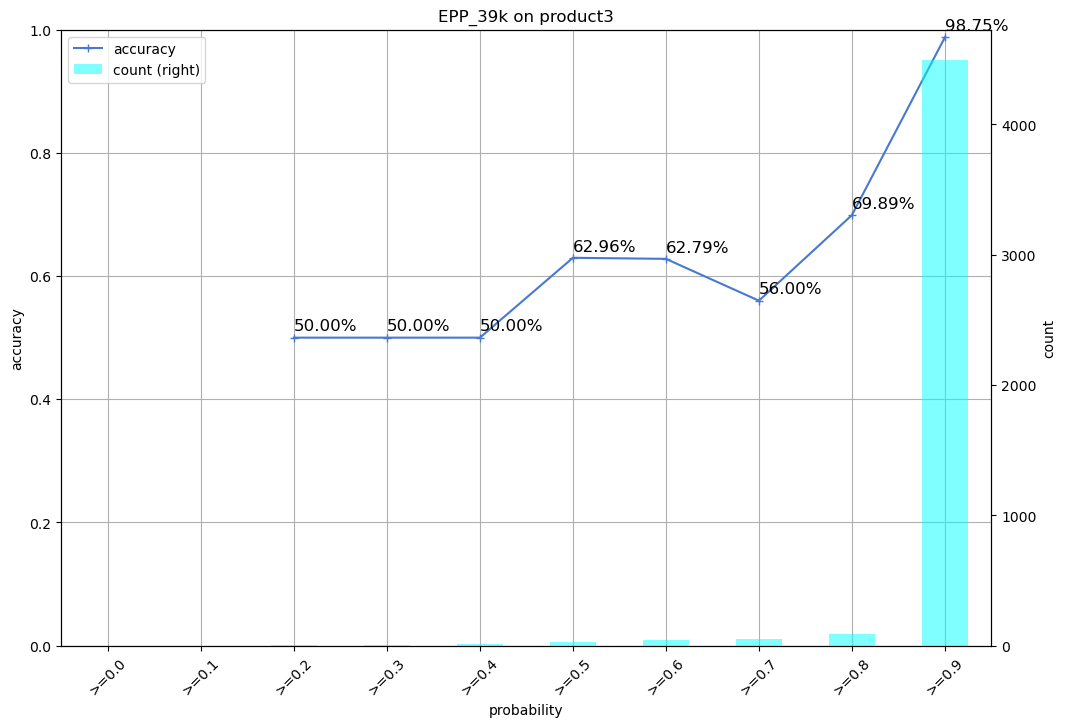

In [15]:
net01 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)

dict_result01 = model_test_prob(
    net=net01,
    test_data=test_data,
    dataProcess=dataProcess,
    folder_name="../model",
    model_name="model01_39k_80.pth",
    device=device,
)
print(dict_result01)
result010=draw_acc_prob(dict_acc_prob=dict_result01, number_label=NUMBER_LABEL, cols=["accuracy", 'balanced_accuracy', "macro_f1", "micro_f1"], text='EPP_39k on ')

../model/model01_151k_80.pth


[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not removing hydrogen atom without neighbors
[10:03:33] WARNING: not r

(18753, 4)
{'product1_prob': {0.0: {'accuracy': [0.058823529411764705, 0.46078431372549017, 0.6274509803921569], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.06572769953051642, 0.38137131685518777, 0.5243121693121693], 'macro_f1': [0.0366412213740458, 0.27801916508558683, 0.5446794001366273], 'micro_f1': [0.058823529411764705, 0.46078431372549017, 0.6274509803921569], 'count': 102}, 0.1: {'accuracy': [0.09433962264150944, 0.5471698113207547, 0.8773584905660378], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.1142857142857143, 0.296875, 0.5820766662829515], 'macro_f1': [0.05990732568402471, 0.21055539919317007, 0.61402140474024], 'micro_f1': [0.09433962264150943, 0.5471698113207547, 0.8773584905660378], 'count': 106}, 0.2: {'accuracy': [0.22988505747126436, 0.6781609195402298, 0.8275862068965517], 'ratio_not_in_vocab': [0.0, 0.0, 0.0], 'balanced_accuracy': [0.2542372881355932, 0.5303379416282642, 0.6628605769230769], 'macro_f1': [0.1391812865497076, 0.4

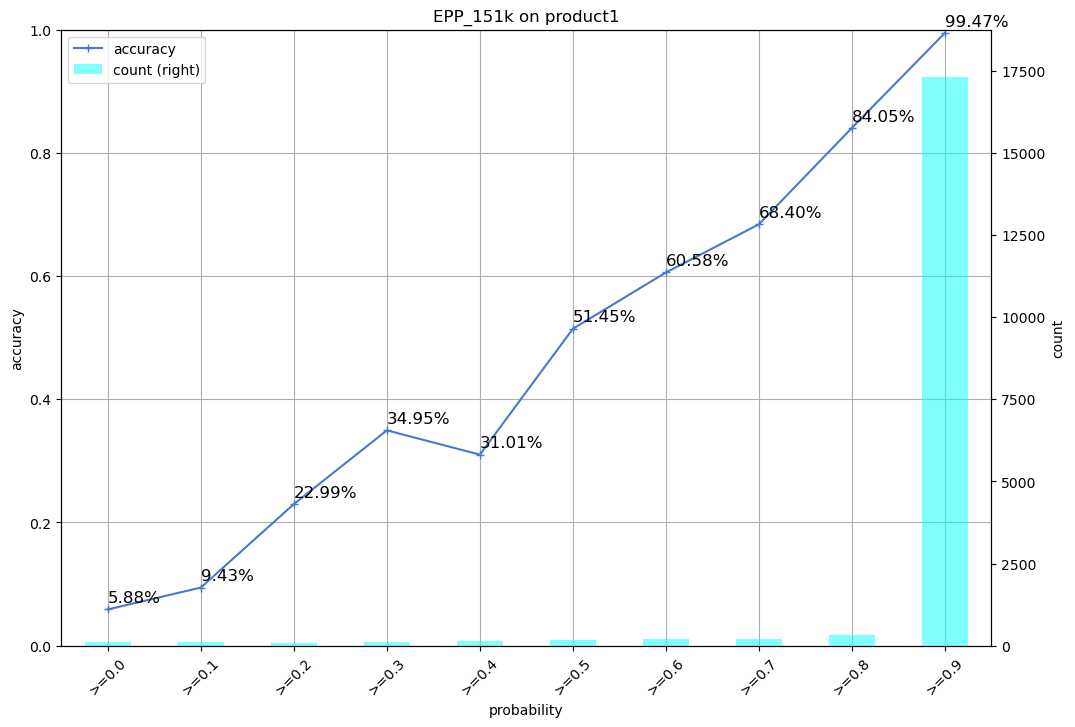

product2_prob
   prob  accuracy ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0  0.019231    [0.0, 0.0, 0.0]           0.025641  0.006849  0.019231   
1   0.1  0.070707    [0.0, 0.0, 0.0]           0.088889  0.050000  0.070707   
2   0.2  0.188235    [0.0, 0.0, 0.0]           0.222222  0.126812  0.188235   
3   0.3  0.178571    [0.0, 0.0, 0.0]           0.240984  0.155658  0.178571   
4   0.4  0.405063    [0.0, 0.0, 0.0]           0.393704  0.272853  0.405063   
5   0.5  0.566845    [0.0, 0.0, 0.0]           0.556324  0.425204  0.566845   
6   0.6  0.714286    [0.0, 0.0, 0.0]           0.712125  0.573390  0.714286   
7   0.7  0.700422    [0.0, 0.0, 0.0]           0.688779  0.575604  0.700422   
8   0.8  0.823980    [0.0, 0.0, 0.0]           0.833382  0.744743  0.823980   
9   0.9  0.993275    [0.0, 0.0, 0.0]           0.943472  0.930633  0.993275   

   count  count_ratio  
0     52     0.002773  
1     99     0.005279  
2     85     0.004533  
3    112     0.00597

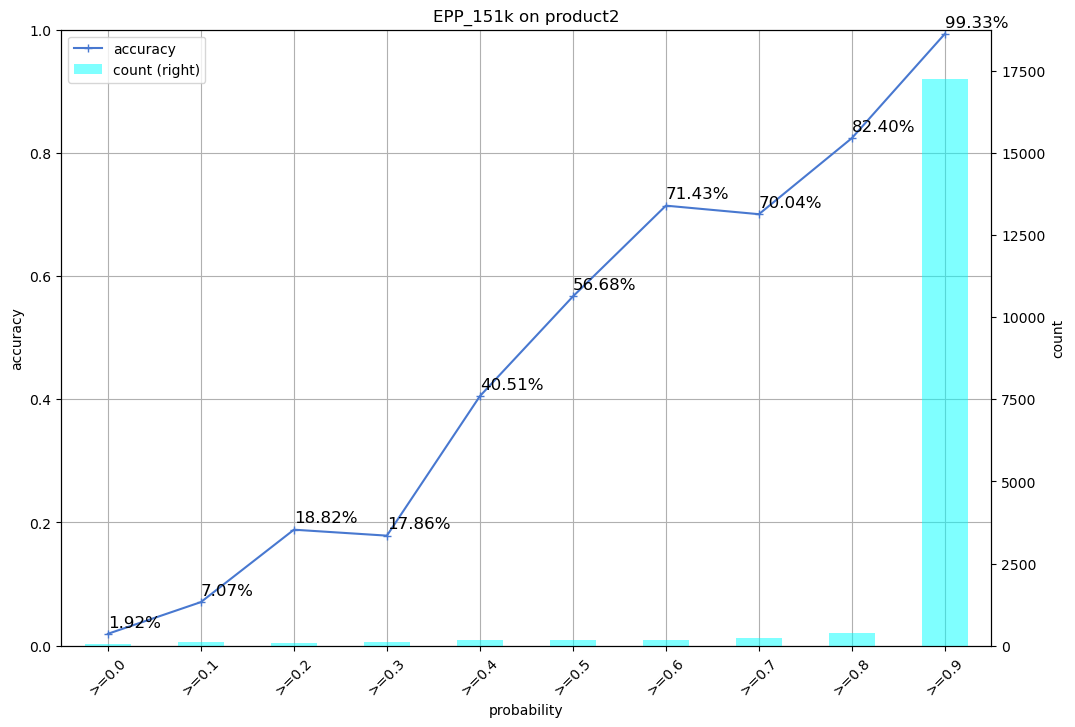

product3_prob
   prob  accuracy ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0  1.000000    [0.0, 0.0, 0.0]           1.000000  1.000000  1.000000   
1   0.1       NaN          [0, 0, 0]                NaN       NaN  0.000000   
2   0.2  0.600000    [0.0, 0.0, 0.0]           0.500000  0.333333  0.600000   
3   0.3  0.375000    [0.0, 0.0, 0.0]           0.550000  0.291667  0.375000   
4   0.4  0.333333    [0.0, 0.0, 0.0]           0.212500  0.139035  0.333333   
5   0.5  0.623377    [0.0, 0.0, 0.0]           0.396937  0.333479  0.623377   
6   0.6  0.537500    [0.0, 0.0, 0.0]           0.536345  0.467423  0.537500   
7   0.7  0.714286    [0.0, 0.0, 0.0]           0.521800  0.403906  0.714286   
8   0.8  0.816667    [0.0, 0.0, 0.0]           0.709123  0.660648  0.816667   
9   0.9  0.991973    [0.0, 0.0, 0.0]           0.727255  0.714398  0.991973   

   count  count_ratio  
0      1     0.000054  
1      0     0.000000  
2      5     0.000268  
3      8     0.00042

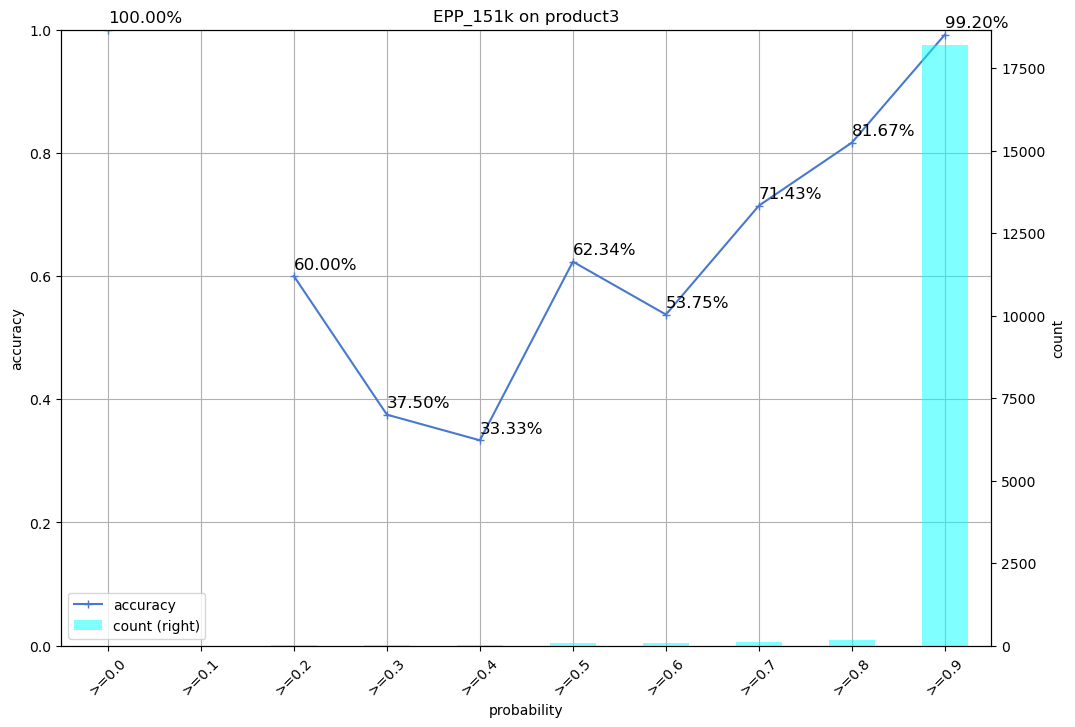

In [10]:
dict_result01 = model_test_prob(
    net=net01,
    test_data=test_data,
    dataProcess=dataProcess,
    folder_name=f"../model",
    model_name="model01_151k_80.pth",
    device=device,
)
print(dict_result01)
result010=draw_acc_prob(dict_acc_prob=dict_result01, number_label=NUMBER_LABEL, cols=["accuracy", 'balanced_accuracy', "macro_f1", "micro_f1"], text='EPP_151k on ')

在其他数据上测试模型
Test the model on other data

In [13]:
path_EC11_SMILES = path_source_EC11.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC11 = dataProcess.get_test_data(
    path=path_EC11_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC11

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAAQRRQNDSSVFLAIMVAAAVESESSLTDGDAGALLLQDISEWDE...,H2O2,,,,,,,,,...,O=O,O,,,,,,,,
1,AAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAADLSHIPTPV...,(S)-malate,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(=O)O)C(=O)O,[H+],,,,,,,
2,ADKKIALVGAGNIGGTLAHLIGLKXLL,(S)-malate,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(=O)O)C(=O)O,[H+],,,,,,,
3,AEPNVTVTGAAGQIGYALLFRI,(S)-malate,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(=O)O)C(=O)O,[H+],,,,,,,
4,AEQQNFLSDLTGSFSSPCNENPTVAMMXISYXXQXIWAS,D-fructose,NADP(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(C(C(=O)CO)O)O)O,[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11184,YIDAETMHLHHDKHHQTYVNNANAALEKHPEIGEDLEALLADVESI...,H(+),superoxide,,,,,,,,...,OO,O=O,,,,,,,,
11185,YIDAETMTLHHDKHHATYVANANAALEKHPEIGEDLEALLADVEQI...,H(+),superoxide,,,,,,,,...,OO,O=O,,,,,,,,
11186,YIDEETMHLHHDKHHQTYVNNVNAALEKHPEIGEDLESLLADVESI...,H(+),superoxide,,,,,,,,...,OO,O=O,,,,,,,,
11187,YIDKETMILHHDKHHATYLANANAALEKHPEIGEDLEFLLSDVTRI...,H(+),superoxide,,,,,,,,...,OO,O=O,,,,,,,,


In [14]:
path_EC27_SMILES = path_source_EC27.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC27 = dataProcess.get_test_data(
    path=path_EC27_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC27

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,ADEKXVVIGLAADSG,ATP,D-ribulose 5-phosphate,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,[H+],,,,,,,
1,AGVDPLVPLRQAMFNYFQVPDRLGILTHLYRIAEGAQQGDPLSRSW...,ATP,N-acetyl-D-glucosamine,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)NC1C(C(C(OC1O)COP(=O)(O)O)O)O,[H+],,,,,,,
2,AKKSVGDLTKADLEGKRVFVRADLNVPLDKEQKXTD,(2R)-3-phosphoglycerate,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(=O)OP(=O)([O-])[O-])O)OP(=O)([O-])[O-],,,,,,,,
3,AKVLTLDLYKKLRDKSTPSGFTLDDIIQNEHLGYVLTCPSNLGTXL...,ATP,creatine,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CN(CC(=O)O)C(=NP(=O)(O)O)N,[H+],,,,,,,
4,ALTEQASKVALTADL,(2R)-3-phosphoglycerate,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(=O)OP(=O)([O-])[O-])O)OP(=O)([O-])[O-],,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13415,VDFNVPIKEGKVKNTTRIQGAIPTLKKILEQNPKNVTLMSHMGRPD...,(2R)-3-phosphoglycerate,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(=O)OP(=O)([O-])[O-])O)OP(=O)([O-])[O-],,,,,,,,
13416,VDFNVPLKDGQVKDPTRIQGSIPSIKKILEQNPKGLVLMSHLGRPD...,(2R)-3-phosphoglycerate,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(=O)OP(=O)([O-])[O-])O)OP(=O)([O-])[O-],,,,,,,,
13417,VDFNVPLKEGVVKDPTRIAGSIPSIKKILETNPRGLVLMSHLGRPD...,(2R)-3-phosphoglycerate,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(=O)OP(=O)([O-])[O-])O)OP(=O)([O-])[O-],,,,,,,,
13418,XEKXIVVGLAADSG,ATP,D-ribulose 5-phosphate,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,[H+],,,,,,,


In [15]:
path_EC31_SMILES = path_source_EC31.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC31 = dataProcess.get_test_data(
    path=path_EC31_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC31

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,2''-O-acetyl-ADP-D-ribose,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)[O-],[H+],,,,,,,
1,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,3''-O-acetyl-ADP-D-ribose,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)[O-],[H+],,,,,,,
2,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,alpha-NAD(+),H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C1=CC(=CN=C1)C(=O)N,[H+],,,,,,,
3,AEFGPSQPFKGAK,H2O,S-adenosyl-L-homocysteine,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N,C(CS)C(C(=O)O)N,,,,,,,,
4,AEGREDPELLVTVRGGRLRGLRLKAPGGPVSAFLGIPFEEPPVGPR...,acetylcholine,H2O,,,,,,,,...,C[N+](C)(C)CCO,CC(=O)[O-],[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,TAVTDIVPDVVVAKDGSGNFTTVGAAVAAAKDSSTARFVIYIKEGA...,[(1->4)-alpha-D-galacturonosyl methyl ester](n),H2O,,,,,,,,...,C1(C(C(OC(C1O)O)C(=O)[O-])O)O,CO,[H+],,,,,,,
3907,TEFGPSQPFKGAK,H2O,S-adenosyl-L-homocysteine,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N,C(CS)C(C(=O)O)N,,,,,,,,
3908,VPSPRPQNATVMVWIFGGGFAYGTSSLNVYDGRYLAQAEGAIVVSM...,acetylcholine,H2O,,,,,,,,...,C[N+](C)(C)CCO,CC(=O)[O-],[H+],,,,,,,
3909,WTLSLLLGAVVGNEVCYERLGCFSDDSPWAGIVERPLKILPWSPEK...,"1,2,3-tributanoylglycerol",H2O,,,,,,,,...,CCCC(=O)C(C(C(C(=O)CCC)O)O)O,CCCC(=O)[O-],[H+],,,,,,,


In [16]:
path_EC42_SMILES = path_source_EC42.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC42 = dataProcess.get_test_data(
    path=path_EC42_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC42

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAVPSGASTGVYEALELRFRAPVEPY,(2R)-2-phosphoglycerate,,,,,,,,,...,C=C(C(=O)O)OP(=O)(O)O,O,,,,,,,,
1,AHAWGYGPTDGPDKWVSNFPIADGPRQSPIDILPGGASYDSGLKPL...,H(+),hydrogencarbonate,,,,,,,,...,C(=O)=O,O,,,,,,,,
2,AIIPKQFLKRIERTGFGQFLFYEWRFDEAGNINPEFEPNKPRYAGA...,"(2R,3S)-3-isopropylmalate",,,,,,,,,...,CC(C)C(CC(=O)O)(C(=O)O)O,,,,,,,,,
3,ASGLMARKQMEQLIKNCDEFNISLYDINNPNQGIVHVIAPEKGMTL...,"(2R,3S)-3-isopropylmalate",,,,,,,,,...,CC(C)C(CC(=O)O)(C(=O)O)O,,,,,,,,,
4,ASMFKHDHYMDNGVRYPNGDGICEQLNETKCDAGFSYDRSICEGPH...,H(+),hydrogencarbonate,,,,,,,,...,C(=O)=O,O,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,VAAAIACALFNLKCKIYMGYKDIKRQSPNVFRMKLMGAEVISVENG...,"(1S,2R)-1-C-(indol-3-yl)glycerol 3-phosphate",L-serine,,,,,,,,...,C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N,C(C(C=O)O)OP(=O)(O)O,O,,,,,,,
7352,VAVSIACALFNLKCKIYMGYKDIKRQSPNVFRMKLMGAEVISVRNG...,"(1S,2R)-1-C-(indol-3-yl)glycerol 3-phosphate",L-serine,,,,,,,,...,C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N,C(C(C=O)O)OP(=O)(O)O,O,,,,,,,
7353,VDRPFKEVEANEGYRLSIDLAEQTLTTPGGETFTFDITEHRKHCLL...,"(2R,3S)-3-isopropylmalate",,,,,,,,,...,CC(C)C(CC(=O)O)(C(=O)O)O,,,,,,,,,
7354,VTKAVENINAIIAPALKGMDPVKQAEIDQKMKDLDGTDNKGKLGAN...,(2R)-2-phosphoglycerate,,,,,,,,,...,C=C(C(=O)O)OP(=O)(O)O,O,,,,,,,,


In [17]:
path_EC56_SMILES = path_source_EC56.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC56 = dataProcess.get_test_data(
    path=path_EC56_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC56

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,MAALPQNNLQKQLELFPAKGTSNKLSLQKTKSSVFTFKKKCSPNVS...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
1,MAAVPLNNLQEQLQRHSARKLNNQPSLSKPKSLGFTFKKKTSEGDV...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
2,MAAVPLRPCRASGRFLPLLRGGARSRGASPWAAGPGRVAQRRYKKD...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
3,MAAVPQNNLQEQLERHSARTLNNKLSLSKPKFSGFTFKKKTSSDNN...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
4,MADREYTLSQKQAINSSGHNILVSASAGSGKTSVLVERVIQKIING...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,MVVASEIAKVASKTARDIAGCFTCQCGTQFDNVERIVQHFKECRYR...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
361,MVVTRGDKFAGSSLACKSMIGANKMSGSHLHEVNNSRSHFPQTNWL...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
362,MVYLRYFKGLILSDAYAPGLKWSDELKAYSALAFKYRDVRKYFLEK...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
363,MWLLLRRAYPLRILLPLRGEWVGRRGLPRSLAPGPPRRRYRKEALP...,ATP,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,


In [18]:
path_EC63_SMILES = path_source_EC63.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC63 = dataProcess.get_test_data(
    path=path_EC63_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC63

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...,GTP,IMP,L-aspartate,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)OP(=O)(O)O)O)O...,[O-]P(=O)([O-])[O-],[H+],,,,,,
1,ALGDQLLSVFVDHTLVDEVA,ATP,H2O,L-glutamine,XMP,,,,,,...,C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)O)O)O)N=C(NC2=O)N,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,[O-]P(=O)([O-])OP(=O)([O-])[O-],C(CC(=O)O)C(C(=O)O)N,[H+],,,,,
2,DPRVRKQYIQEQGAPIVIKADGLAAGKGVTVAMTLEEAYKAVDSML...,5-phospho-beta-D-ribosylamine,ATP,glycine,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(C1C(C(C(O1)NC(=O)C[NH3+])O)O)OP(=O)([O-])[O-],[O-]P(=O)([O-])[O-],[H+],,,,,,
3,EFLNSSVKIVNPIMGVKFWDENVRIPAEEVTVRFERGHPVALNGQT...,ATP,L-aspartate,L-citrulline,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,C(CC(C(=O)O)N)CN=C(N)NC(CC(=O)O)C(=O)O,[O-]P(=O)([O-])OP(=O)([O-])[O-],[H+],,,,,,
4,IRAGDAVIAMASSGLHSNGYSLVRHVLFDGAGYALDREIPEFGRTL...,2-formamido-N(1)-(5-O-phospho-beta-D-ribosyl)a...,ATP,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C1=C(N(C=N1)C2C(C(C(O2)COP(=O)(O)O)O)O)N,[O-]P(=O)([O-])[O-],[H+],,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,TMVTKLEKDSLVSKLYNSDVALERHRHRYEFNNKYKKDLESVGLRF...,ATP,H2O,L-glutamine,UTP,,,,,,...,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,C(CC(=O)O)C(C(=O)O)N,[O-]P(=O)([O-])[O-],[H+],,,,,
8434,TMVTKLEKDSLVSKLYNSDVALERHRHRYEFNNKYKKDLESVGLRF...,ATP,NH4(+),UTP,,,,,,,...,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,
8435,TMVTKLEKDSLVSKLYNSDVALERHRHRYEFNNKYKKDLESVGLRF...,H2O,L-glutamine,,,,,,,,...,C(CC(=O)O)C(C(=O)O)N,[NH4+],,,,,,,,
8436,WFDPLRITETTTGSVTLK,ATP,L-aspartate,L-citrulline,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,C(CC(C(=O)O)N)CN=C(N)NC(CC(=O)O)C(=O)O,[O-]P(=O)([O-])OP(=O)([O-])[O-],[H+],,,,,,


In [19]:
path_EC71_SMILES = path_source_EC71.replace(f'{DATE}', f'{DATE}_SMILES')
test_data_EC71 = dataProcess.get_test_data(
    path=path_EC71_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_EC71

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,diphosphate,H(+),H2O,,,,,,,...,[O-]P(=O)([O-])[O-],[H+],,,,,,,,
1,AFENKLMKNYRFLGISTSSEGYITQIIGPVLDVAFPVGKMPNIFNS...,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
2,AGGIAEMSGLPEDVRKTTDALDAVGNTTKAVTKGYAIGSAGLAALV...,diphosphate,H(+),H2O,,,,,,,...,[O-]P(=O)([O-])[O-],[H+],,,,,,,,
3,AIGSAGLGALVLFAAYSNDLSYFAANGDKYPYFANIGEISFDLSNP...,diphosphate,H(+),H2O,,,,,,,...,[O-]P(=O)([O-])[O-],[H+],,,,,,,,
4,ASSAAAAXAPSTPLA,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,VGYITQIIGPVLDVAPSPGKMPNIYNSLIVKGRNPAGQDINVTCEV...,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
2462,VLIMELINNVAKAHGGYTVFAGVGERTREGNDLYHEMIESGVISLK...,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
2463,VLNTGSPITVPVGRVGLTGLTVAEHFRFTQANSEVSALLGRIPSAV...,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,
2464,VQAIYVPADDLTDPAPATTFAHLDATTVLSRQISELGIYPAVDPLD...,ATP,H(+),H2O,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,[O-]P(=O)([O-])[O-],[H+],,,,,,,


In [20]:
path_source_CA = f"../data/data_reviewed_CA_{DATE}01.tsv"
path_CA_SMILES = path_source_CA.replace(f'{DATE}01', f'{DATE}01_SMILES')
test_data_CA = dataProcess.get_test_data(
    path=path_CA_SMILES, data=data01, cols=["Sequence",
            ]
)
test_data_CA

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...,GTP,IMP,L-aspartate,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)OP(=O)(O)O)O)O...,[O-]P(=O)([O-])[O-],[H+],,,,,,
1,AAAQRRQNDSSVFLAIMVAAAVESESSLTDGDAGALLLQDISEWDE...,H2O2,,,,,,,,,...,O=O,O,,,,,,,,
2,AAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAADLSHIPTPV...,(S)-malate,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(=O)O)C(=O)O,[H+],,,,,,,
3,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,2''-O-acetyl-ADP-D-ribose,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)[O-],[H+],,,,,,,
4,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,3''-O-acetyl-ADP-D-ribose,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)[O-],[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112046,YYTPEYKTKDTDILAAFRMTPQPGVPAEEAGAAVAAESSTGTWTTV...,(2R)-3-phosphoglycerate,H(+),,,,,,,,...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,C(=O)=O,O,,,,,,,
112047,YYTPEYKTKDTDILAAFRMTPQPGVPAEEAGAAVAAESSTGTWTTV...,"D-ribulose 1,5-bisphosphate",O2,,,,,,,,...,C(C(C(=O)[O-])O)OP(=O)([O-])[O-],C(C(=O)[O-])OP(=O)([O-])[O-],[H+],,,,,,,
112048,YYTPKYETKDTDILAAFRMTPQPGVPPEEAGAAVAAESSTGTWTTV...,(2R)-3-phosphoglycerate,H(+),,,,,,,,...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,C(=O)=O,O,,,,,,,
112049,YYTPKYETKDTDILAAFRMTPQPGVPPEEAGAAVAAESSTGTWTTV...,"D-ribulose 1,5-bisphosphate",O2,,,,,,,,...,C(C(C(=O)[O-])O)OP(=O)([O-])[O-],C(C(=O)[O-])OP(=O)([O-])[O-],[H+],,,,,,,


../model model01_39k_80.pth all_EC: 112051
../model/model01_39k_80.pth


[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not removing hydrogen atom without neighbors
[20:51:39] WARNING: not r

../model model01_39k_80.pth EC1.1: 11189
../model/model01_39k_80.pth


[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not removing hydrogen atom without neighbors
[23:21:31] WARNING: not r

../model model01_39k_80.pth EC2.7: 13420
../model/model01_39k_80.pth


[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:30] WARNING: not removing hydrogen atom without neighbors
[23:36:35] WARNING: not removing hydrogen atom without neighbors
[23:36:39] WARNING: not removing hydrogen atom without neighbors
[23:37:14] WARNING: not r

../model model01_39k_80.pth EC3.1: 3911
../model/model01_39k_80.pth


[23:54:35] WARNING: not removing hydrogen atom without neighbors
[23:55:21] WARNING: not removing hydrogen atom without neighbors
[23:55:52] WARNING: not removing hydrogen atom without neighbors
[23:56:11] WARNING: not removing hydrogen atom without neighbors
[23:56:24] WARNING: not removing hydrogen atom without neighbors
[23:56:51] WARNING: not removing hydrogen atom without neighbors
[23:58:16] WARNING: not removing hydrogen atom without neighbors
[23:58:45] WARNING: not removing hydrogen atom without neighbors


../model model01_39k_80.pth EC4.2: 7356
../model/model01_39k_80.pth


[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:46] WARNING: not removing hydrogen atom without neighbors
[23:59:57] WARNING: not removing hydrogen atom without neighbors
[00:00:05] WARNING: not removing hydrogen atom without neighbors
[00:00:09] WARNING: not removing hydrogen atom without neighbors
[00:00:10] WARNING: not removing hydrogen atom without neighbors
[00:00:33] WARNING: not r

../model model01_39k_80.pth EC5.6: 365
../model/model01_39k_80.pth
../model model01_39k_80.pth EC6.3: 8438
../model/model01_39k_80.pth


[00:14:32] WARNING: not removing hydrogen atom without neighbors


../model model01_39k_80.pth EC7.1: 2466
../model/model01_39k_80.pth


[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not removing hydrogen atom without neighbors
[00:21:31] WARNING: not r

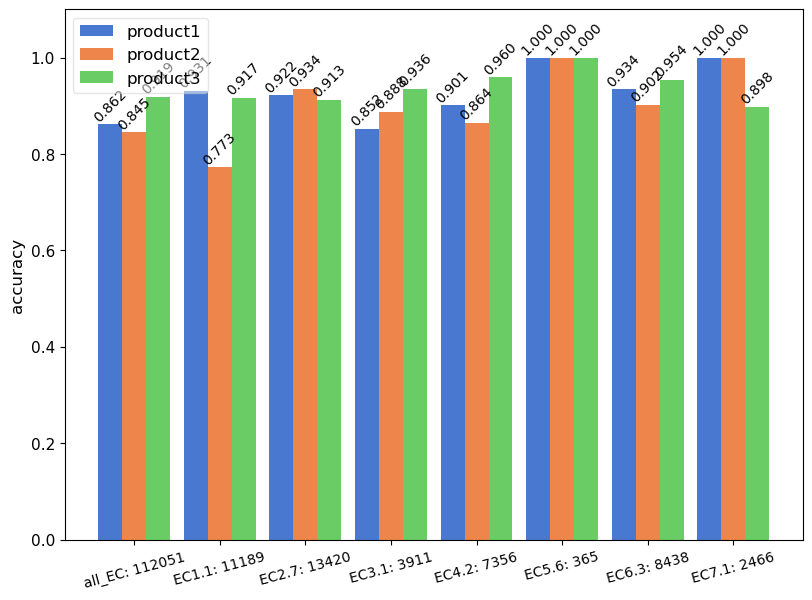

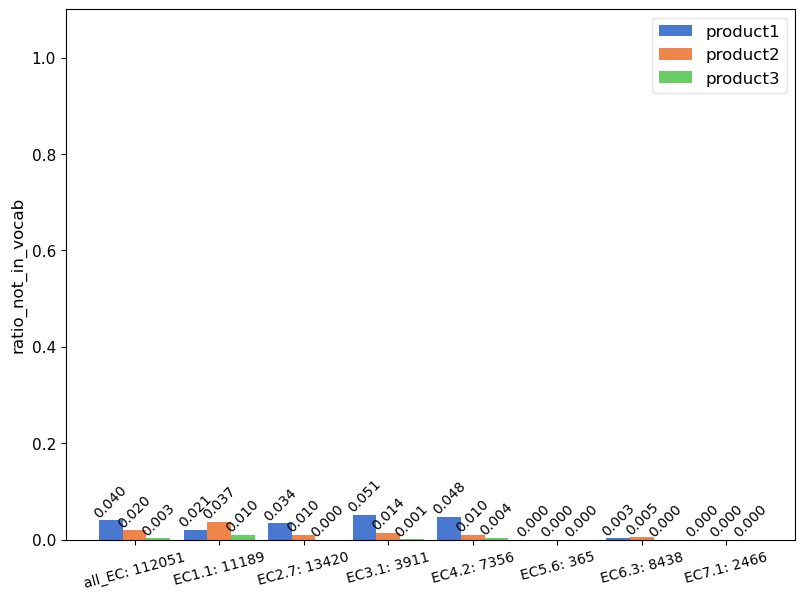

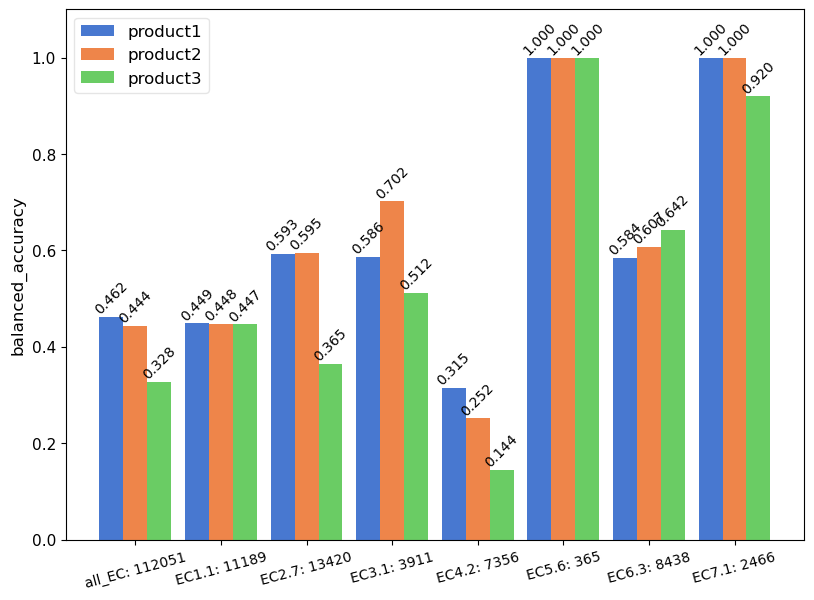

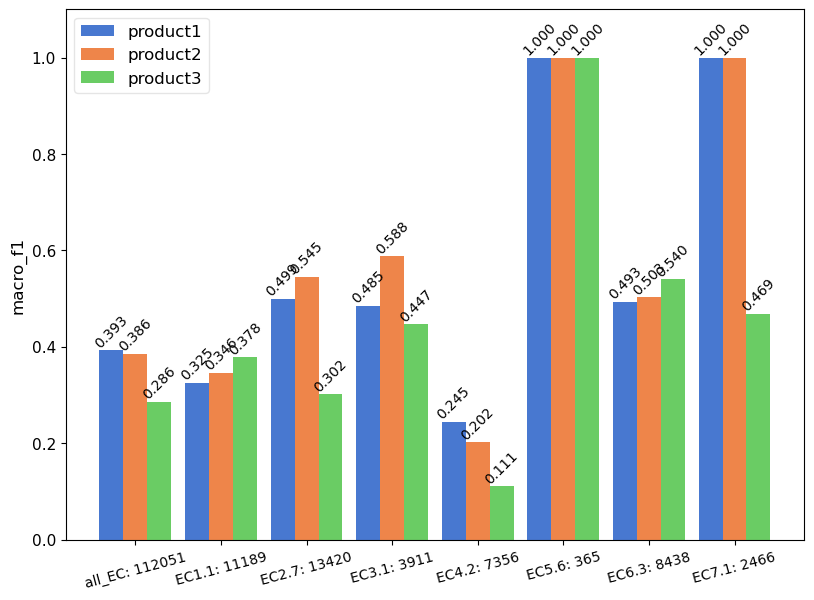

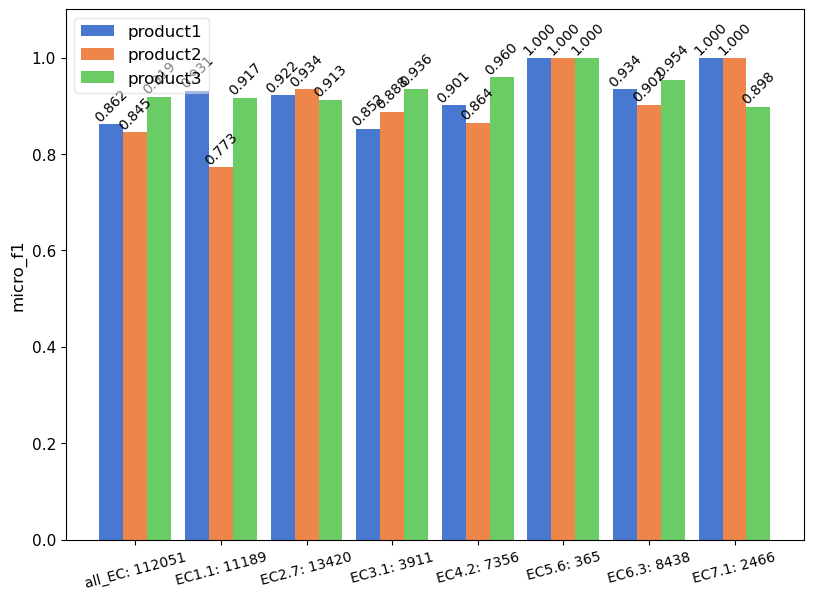

In [21]:
list_model = [
    {
        "model_name": f"all_EC: {test_data_CA.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_CA,
    },
    {
        "model_name": f"EC1.1: {test_data_EC11.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC11,
    },
    {
        "model_name": f"EC2.7: {test_data_EC27.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC27,
    },    
    {
        "model_name": f"EC3.1: {test_data_EC31.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC31,
    },
    {
        "model_name": f"EC4.2: {test_data_EC42.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC42,
    },
    {
        "model_name": f"EC5.6: {test_data_EC56.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC56,
    },
    {
        "model_name": f"EC6.3: {test_data_EC63.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC63,
    },
    {
        "model_name": f"EC7.1: {test_data_EC71.shape[0]}",
        "net": net01,
        "path_model": "model01_39k_80.pth",
        "path_folder": "../model",
        'test_data': test_data_EC71,
    },
]

arr_acc021, arr_balanced_acc021, arr_macro_f1021, arr_micro_f1021, arr_ratio_not_in_vocab021 = calculate_multi_model(
        list_model=list_model, 
        dataProcess=dataProcess,
        device=device
    )

dict_arr_acc04 = {
    "accuracy": arr_acc021,
    'ratio_not_in_vocab': arr_ratio_not_in_vocab021,
    "balanced_accuracy": arr_balanced_acc021,
    "macro_f1": arr_macro_f1021,
    "micro_f1": arr_micro_f1021,
}
draw_acc_bar(
    list_x=[x["model_name"] for x in list_model],
    dict_arr_acc=dict_arr_acc04,
    xtext='',
)

../model/model01_39k_80.pth


[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not removing hydrogen atom without neighbors
[00:24:53] WARNING: not r

(112051, 4)
{'product1_prob': {0.0: {'accuracy': [0.04094292803970223, 0.3970223325062035, 0.598428453267163], 'ratio_not_in_vocab': [0.41273779983457404, 0.09511993382961124, 0.00041356492969396195], 'balanced_accuracy': [0.0376082489626124, 0.15329407405021303, 0.24436633730698643], 'macro_f1': [0.019619559940110953, 0.10803801776939703, 0.2524317970245801], 'micro_f1': [0.04094292803970223, 0.3970223325062035, 0.598428453267163], 'count': 2418}, 0.1: {'accuracy': [0.20956059874456784, 0.44857556735876386, 0.8329309512312892], 'ratio_not_in_vocab': [0.34379526798647997, 0.04780299372283921, 0.0004828585224529213], 'balanced_accuracy': [0.17974992343029866, 0.22119102947025632, 0.2458768546579212], 'macro_f1': [0.1019343314090882, 0.16106239109995882, 0.2559288437651244], 'micro_f1': [0.20956059874456784, 0.44857556735876386, 0.8329309512312892], 'count': 2071}, 0.2: {'accuracy': [0.3761658031088083, 0.5580310880829016, 0.883937823834197], 'ratio_not_in_vocab': [0.15077720207253886, 0

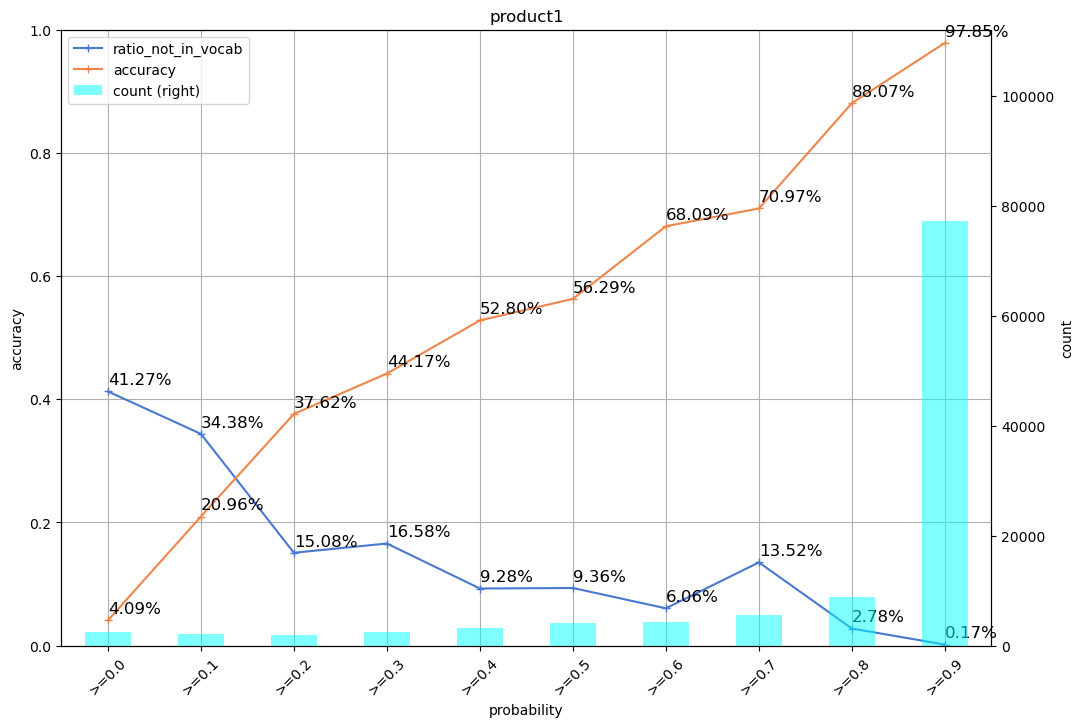

product2_prob
   prob  accuracy  ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0  0.029273            0.655335           0.037595  0.016917  0.029273   
1   0.1  0.157614            0.162066           0.103844  0.060150  0.157614   
2   0.2  0.220869            0.101165           0.196311  0.128592  0.220869   
3   0.3  0.335583            0.052555           0.298005  0.212244  0.335583   
4   0.4  0.407993            0.029697           0.407838  0.304874  0.407993   
5   0.5  0.530405            0.017375           0.521676  0.427233  0.530405   
6   0.6  0.628740            0.021908           0.625827  0.522894  0.628740   
7   0.7  0.725097            0.014888           0.731019  0.661121  0.725097   
8   0.8  0.860728            0.005102           0.833645  0.795158  0.860728   
9   0.9  0.961073            0.005572           0.823387  0.813783  0.961073   

   count  count_ratio  
0   1059     0.009451  
1   2246     0.020044  
2   1888     0.016849  
3   2074 

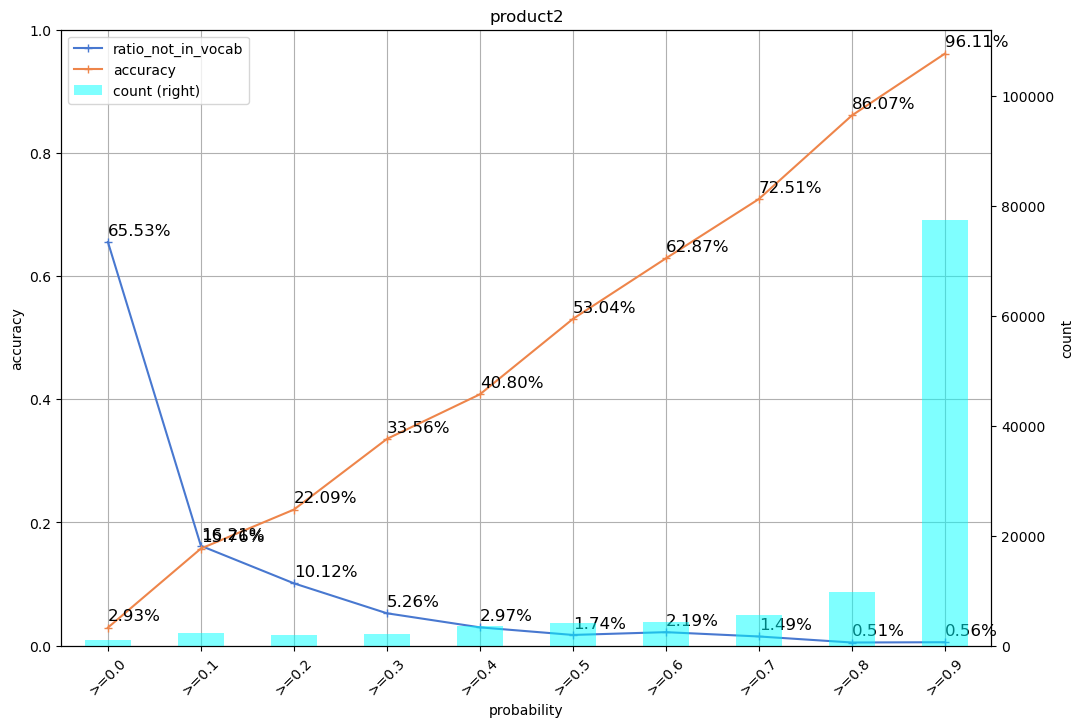

product3_prob
   prob  accuracy  ratio_not_in_vocab  balanced_accuracy  macro_f1  micro_f1  \
0   0.0       NaN            0.000000                NaN       NaN  0.000000   
1   0.1  0.132743            0.097345           0.087398  0.046561  0.132743   
2   0.2  0.203883            0.038835           0.126752  0.084071  0.203883   
3   0.3  0.430796            0.005190           0.248666  0.160771  0.430796   
4   0.4  0.435959            0.002387           0.326765  0.219001  0.435959   
5   0.5  0.457193            0.001765           0.294158  0.169871  0.457193   
6   0.6  0.576121            0.000444           0.407081  0.306283  0.576121   
7   0.7  0.729710            0.003672           0.577193  0.481132  0.729710   
8   0.8  0.829419            0.003502           0.569401  0.501225  0.829419   
9   0.9  0.958306            0.002513           0.377635  0.379577  0.958306   

   count  count_ratio  
0      0     0.000000  
1    113     0.001008  
2    103     0.000919  
3    578 

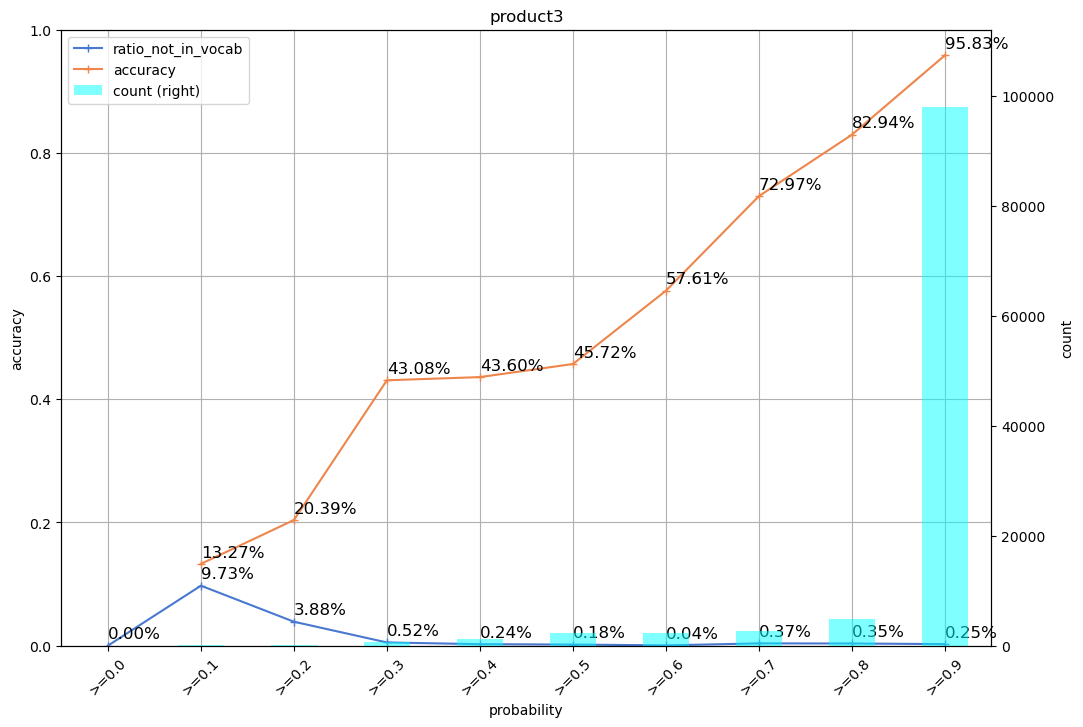

In [22]:
dict_result051 = model_test_prob(
    net=net01,
    test_data=test_data_CA,
    dataProcess=dataProcess,
    folder_name="../model",
    model_name="model01_39k_80.pth",
    device=device,
)
print(dict_result051)
result021=draw_acc_prob(dict_acc_prob=dict_result051, number_label=NUMBER_LABEL, text = '')

In [28]:
# 定义计算皮尔逊相关系数的函数
def get_correlation(list):
    # 定义结果
    results = []
    for i, df in enumerate(list):
        # 计算皮尔逊相关系数
        correlation = np.corrcoef(df['prob'][:10], df['ratio_not_in_vocab'][:10])[0,1]
        # print(i, correlation)
        results.append(correlation)
    return results

correlation_EPP_80=get_correlation(result021)
correlation_EPP_80

[-0.8719007374937863, -0.6892527843472268, -0.48885976194645886]